# Description
This code implements 1D Dilated convolutional DenseNet for machine learning on time-series with domain adversarial regularization.The dilated convolutions were used inspired by the WaveNet architecture [2]. The implementation follows the findings of the original paper on DenseNets [1] with some small differences.

* Each convolution block is a composite operation with "1x1" 1D convolution (A better term would be "filter-wise multiplication), BatchNorm, 1D Convolution with kernel size $k$
* Dilated convolutions are used (dilation $d$) in order to have a larger receptive field and facilitate the learning of multi-scale features
* Instead of explicitly concatenating the layers they are kept in a list. The original implementation was in pytorch and some memory efficiency condiderations ([1] section 3.2.1)- it seems TensorFlow is smart enough not to make redundant copies in-memory for the operations.
* Adversarial domain generalization is achieved with the gradient reversal technique described in [2]


## References
[[1]](https://ieeexplore.ieee.org/document/8721151) Convolutional Networks with Dense Connectivity

[[2]](https://arxiv.org/abs/1609.03499) A Generative Model for Raw Audio

[[3]](https://arxiv.org/abs/1505.07818) Domain-Adversarial Training of Neural Networks
## Usage
Three separate json files are used for managing 
* the pre-processing of the data
* the network parametrization
* the training 

Model checkpoints and training/validation losses are saved to disk for subsequent manual inspection for model selection.

### Network structure definition
The network structure is parametrized by a single json file, that contains the input shape, different layer stacks and at least two outputs. One of the inputs should have the property `"id":"timeseries_input"`. This defines the input layer of the time-series. Although the network can produce results for time-series of arbitrary lengths, the length of the time-series during training is required. The input with `"id":"domain_input"` is used for the domain adversarial loss from the $G_d$ classifier and it is also required.




# UNDER CONSTRUCTION! 
* dataset not publicly available
* will be updated with a publicly available dataset


In [1]:
import tensorflow as tf
#tf.enable_eager_execution()
import tensorflow.keras as keras
import numpy as np
import matplotlib.pyplot as pplot
from tensorflow.keras import Model
from tensorflow.keras.layers import Input, Dense, Conv1D, AveragePooling1D, GlobalAveragePooling1D, Flatten, BatchNormalization, Dropout
from sklearn.decomposition import PCA

import os

gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        # Currently, memory growth needs to be the same across GPUs
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
            logical_gpus = tf.config.experimental.list_logical_devices('GPU')
            print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
    except RuntimeError as e:
        # Memory growth must be set before GPUs have been initialized
        print(e)


#from tensorflow.compat.v1 import ConfigProto
#from tensorflow.compat.v1 import InteractiveSession
#config = ConfigProto()
#config.gpu_options.allow_growth = True
#sess = InteractiveSession(config=config)
#tf.keras.backend.set_session(sess)
confusion_matrix = tf.math.confusion_matrix
from src.dilated_densenet_adversarial import make_model, make_densenet_parametrization_dictionary

1 Physical GPUs, 1 Logical GPUs


In [2]:
%load_ext autoreload
%autoreload 
#%debug
#from src.dilated_densenet_adversarial import make_model
#from src.dilated_densenet_adversarial import make_densenet_parametrization_dictionary
from src.util import plot_confusion_matrix
from src.experiments_utils import *
#from src.dilated_densenet_adversarial import *

ndn = 5
ndn2 = 5

experiment_parametrization = {
    'dilation_rates_dn1': [2,4,8,16,32,64,128,512,8,16,32,64,128,512],#,4,8,16,32],
    'kernel_sizes_dn1' :  [10] * ndn,#,5,5],
    'nfilters_dn1' :  [20]*ndn,
    'dilation_rates_dn2' : [4]*ndn2,
    'kernel_sizes_dn2' : [5]*ndn2,
    'nfilters_dn2': [10]*ndn2
}

make_network_description_experiments_A(**experiment_parametrization)
model_json = make_network_json_experiments_A(**experiment_parametrization)
#model_json['domain_classifier']['network_layers'][0]['params']['units'] = 500
#model_json['classifier']['network_layers'][0]['params']['units'] = 500


# pred_c = {
#     'network_layers': [
#         {
#             'type': 'Dense',
#             'id': 'prediction',
#             'params': {'units': 10, 'name': 'Y_output'}
#         }
#     ]
# }
# pred_d = {
#     'network_layers': [
#         {
#             'type': 'Dense',
#             'id': 'prediction',
#             'params': {'units': 3, 'name': 'ExpID'}
#         }
#     ]
#}
# model_json['classifier'] = pred_c
# model_json['domain_classifier'] = pred_d
#
model_json["classifier"]["network_layers"][-1]['params']['units'] = 10
model_json["densenet_1d"]["network_layers"][0]["params"]["Variational"] = False
model_json["densenet_1d"]["network_layers"] = [
    model_json["densenet_1d"]["network_layers"][0],model_json["densenet_1d"]["network_layers"][-1]
]
#model_json['domain_classifier']['network_layers'][0]['type'] = 'DenseLocalReparameterization'
#del model_json['domain_classifier']['network_layers'][0]['params']["use_bias"]
#model_json['classifier']['network_layers'][0]['type'] = 'DenseLocalReparameterization'
#del model_json['classifier']['network_layers'][0]['params']['use_bias']
model_json['inputs'][0]['shape'] = (1500,6)


#model.summary()
model_json['domain_classifier']['network_layers'][-1]['params']['units'] = 4;

In [3]:
def plot_dn_output_activation_statistics():
    p1 = inspect_model.predict(Xtrain[::123,:,:], batch_size=50)
    p2 = inspect_model.predict(Xtest[::123,:,:], batch_size=50)
    #pout_test = inspect_model2.predict(Xtest[::123,:,:], batch_size=50)
    pplot.figure(figsize = (20,10))
    
    def plt_stuff(iistart, stuff):
        iistart+=1; pplot.subplot(2,4,iistart)
        pplot.pcolor(np.mean(stuff,1))
        pplot.title('mean - train - sl1')
        iistart+=1; pplot.subplot(2,4,iistart)
        pplot.pcolor(np.std(stuff,1))
        pplot.title('std - train - sl1')
        iistart+=1; pplot.subplot(2,4,iistart)
        pplot.pcolor(np.mean(stuff,0))
        pplot.title("mean - test - sl0")    
        iistart+=1; pplot.subplot(2,4,iistart)
        pplot.pcolor(np.std(stuff,0))
        pplot.title("std - test - sl0")
    plt_stuff(0,p1)
    plt_stuff(4,p2)
    
# plot_dn_output_activation_statistics()

# Data preparation 
Normally there are two more time-consuming pre-processing steps.Namely,
 * The data are first sub-sampled (to 200 cycles every 20000 cycles) and then
 * each cycle is re-sampled to have the same number of points, namely 300 points per cycle.  

In this post-processing stage, a certain ammount of cycles from the end is considered (150k ~ 300k) because any prediction for cycles earlier than that should not work for physical reasons (and since we are having limited experiments). In this final stage of pre-processing unique re-sampled cycles are bundled to *blocks* so that they have more information about the mechanical response of the material. 

In previous attempts prediction was shown to be possible using even a single cycle. With more cycles it is potentially possible to get better accuracy.

In [ ]:
from src.util import load_hilti_fatigue_data
#del data
data = load_hilti_fatigue_data(keep_from_end = 100000,leave_exp_out="None",stage_2_from_disk=True, nclasses = 10)
static_normalization = data['normalization']

proc:1
proc:2


In [5]:
[X_all_0,Y_all_0,Yoh_all_0, eid_vector_all_0] = data['training_instances']

In [6]:
X_all_0.shape

(9169, 1500, 6)

In [7]:
#pplot.figure(figsize = (10,20))
#pplot.plot(X_all_0[:,:,1])
np.any(X_all_0[:,:,1]>0.45,1).shape
Y_all_0.shape

(9169,)

In [8]:
f_more = np.any(X_all_0[:,:,1]>0.35,1)
f_more = np.max((X_all_0[:,:,1]>0.45)*(X_all_0[:,:,1]>0.0),1)

een = eid_vector_all_0 == 'VA_3'
yy = Y_all_0
f_more = f_more * een
ids_1 = np.where((yy>80000)*f_more)[0][1]
ids_2 = np.where((yy<70000)*(yy>30000)*f_more)[0][0]
ids_3 = np.where((yy<5000)*(yy>0)*f_more)[0][0]
ids_1,ids_2, ids_3

(4966, 5282, 6602)

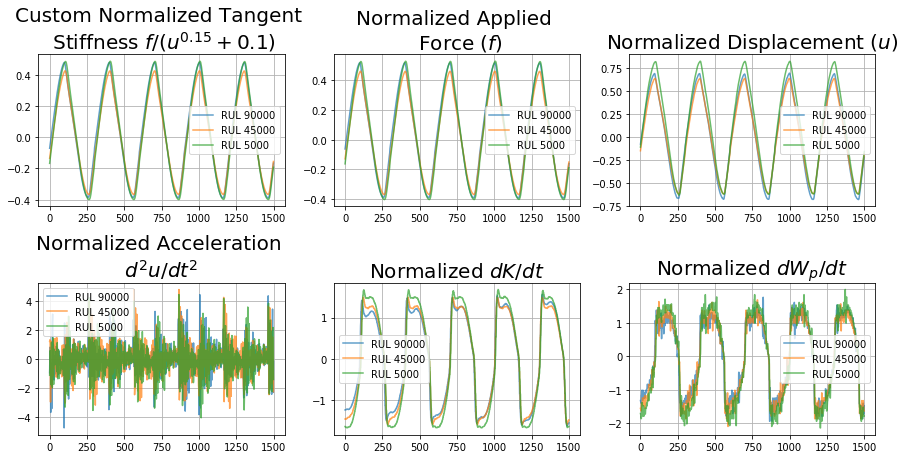

In [9]:
#ax = pplot.figure(figsize = (10,5), dpi = 600)
#fig, axes = pplot.subplots(6, 1, subplot_kw=dict(sharex=True))
fig = pplot.figure(figsize = (15,7) )
ax = fig.subplots(2, 3)
nX = 432
flat_ax = [item for elem in ax for item in elem];

titles = ["Custom Normalized Tangent \n Stiffness $f/(u^{0.15} + 0.1)$ ","Normalized Applied \n Force ($f$)","Normalized Displacement ($u$)",
"Normalized Acceleration \n$d^2u/dt^2$","Normalized $dK/dt$","Normalized $dW_p/dt$"]
def plt_nx(nX):
    for k in [0,1,2,3,4,5]:
        flat_ax[k].plot(X_all_0[nX,:,k], alpha = 0.7)
        flat_ax[k].set_title(titles[k])
        
    
    
#fig.subplots_adjust(wspace = 40)
#     pplot.plot(X_all_0[nX][:,4])


plt_nx(ids_1)
plt_nx(ids_2)
plt_nx(ids_3)
fig.subplots_adjust(hspace = 0.5)

for ax_ in flat_ax:
    ax_.grid()
    ax_.title.set_fontsize(20)
    ax_.legend(["RUL 90000","RUL 45000","RUL 5000"])
#flat_ax[-1]
#pplot.subplots_adjust
fig.savefig("raw_data_plots.pdf")
#pplot.subplots_adjust(wspace = 30)
#pplot.plot(X_all_0[0][:,1])

#pplot.show()
#pplot.plot(X_all_0[654][:,0])
#pplot.plot(X_all_0[654][:,1])
#ax[1].plot([1,2,3])

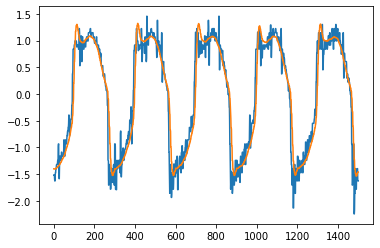

In [10]:
pplot.plot(X_all_0[0][:,5])
pplot.plot(X_all_0[0][:,4])


In [11]:

def col_norm(xx):
    for ii in range(5):
        xx[:,:,ii] = (xx[:,:,ii].T + abs(np.min(xx[:,:,ii],-1))).T
        xx[:,:,ii] = (xx[:,:,ii].T / abs(np.max(xx[:,:,ii],-1))).T
    return xx
#X_all_0 = col_norm(X_all_0)

In [12]:
ids_trainVal = Y_all_0<np.inf
[X_all, Y_all, Yoh_all, eid_vector_all] = [xxx[ids_trainVal] for xxx in  [X_all_0,Y_all_0,Yoh_all_0, eid_vector_all_0]]



In [13]:
#X_all = X_all[:,:,2:]

In [14]:
from ipywidgets import interact, interactive,IntSlider
print("\t Assumption is that since the data presents with a wide range of freq. \n content, different in every channel, we need flow of multi-scale\n information all over the network.")
@interact(idx = IntSlider(min = 0, max = 10000,step = 10))
def aa(idx):
    #pplot.plot(X_all_0[idx][:,0],X_all_0[idx][:,1])
    pplot.figure(figsize = (10,5))
    pplot.subplot(2,1,1)
    pplot.plot(X_all_0[idx][:,3])
    pplot.title("Accelerations")
    pplot.subplot(2,1,2)
    pplot.plot(X_all_0[idx][:,4])
    pplot.title("\"tangent stiffness\"")
    pplot.subplots_adjust(hspace = 1)
    pplot.show()
    

	 Assumption is that since the data presents with a wide range of freq. 
 content, different in every channel, we need flow of multi-scale
 information all over the network.


interactive(children=(IntSlider(value=0, description='idx', max=10000, step=10), Output()), _dom_classes=('wid…

In [15]:
Yoh_all = Yoh_all[:,~np.all(Yoh_all == 0, axis = 0)]

In [16]:
#model_json['domain_classifier']['network_layers'][-1]['params']['units'] = 3


## Other sources of potential bias:
Another source of potential bias in this application is the range of the loading. We don't want the load range to be used for predicting the cycles to failure because there is no causal relation between this and the fatigue RUL. An additional adversarial classifier is created for these unwanted biases too.

In the following the labels are created for that, through some manual thresholding of values.

In [17]:

# I need a couple of more stuff I need to reg. against
DA2_0 = np.max(X_all_0[:,:,1],-1)
DA3_0 = np.min(X_all_0[:,:,0],-1)
q0 = np.quantile(DA2_0,np.linspace(0,1,400))
q1=np.quantile(DA3_0,np.linspace(0,1,400))
#pplot.plot(q1,'.')
qs0 = [0.25,0.30,0.35,0.40,0.45,0.50]
qs1 = [-0.38,-0.35,-0.32,-0.28]

c0_0 = np.zeros_like(DA2_0);
c1_0 = np.zeros_like(DA3_0);
for qq0 in qs0:
    c0_0 = c0_0 +  (DA2_0<qq0) * 1
    
for qs1 in qs1:
    c1_0 = c1_0 +  (DA3_0<qs1) * 1
    
def onehot(v, valrange = None):
    if valrange is None:
        valrange = int(np.max(v)+1)
    z = np.zeros([v.shape[0], valrange])
    for i_,z_ in zip(v,z[:]):
        z_[int(i_)] = 1
        
    return z


c0_0_oh = onehot(c0_0)
c1_0_oh = onehot(c1_0)


In [18]:

    
z

NameError: name 'z' is not defined

In [20]:
#tf.one_hot(c0_0, tf.unique(c0_0))


In [21]:
leave_exp_out = 'VA_123'
#model = make_model(model_json)

Yoh_all[np.all(Yoh_all[:,0:10]==0)] = np.ones_like(Yoh_all[np.all(Yoh_all[:,0:10]==0)])
[X,Y,Yoh,eid_vector, coh0, coh1] = [cc[eid_vector_all != leave_exp_out] for cc in [X_all, Y_all, Yoh_all, eid_vector_all, c0_0_oh, c1_0_oh]]
[Xstrong,Ystrong,YstrongOH,eid_vector_strong, c0_oh_strong, c1_oh_strong] = [cc[eid_vector_all == leave_exp_out] for cc in [X_all, Y_all, Yoh_all, eid_vector_all, c0_0_oh, c1_0_oh]]


In [22]:
np.unique(eid_vector), Yoh.shape

(array(['VA_1', 'VA_2', 'VA_3', 'VA_4'], dtype=object), (9169, 10))

# Train/Test split and Training

In [23]:
Y_classes = np.argmax(Yoh,1)
ystrat = Y_classes + (np.argmax(coh0,1)) + (np.argmax(coh1,1))


In [24]:

from sklearn.model_selection import train_test_split

Y_classes = np.argmax(Yoh,1)
EidOH = np.zeros([eid_vector.shape[0],len(np.unique(eid_vector))])
nexperiments = len(np.unique(eid_vector));
for i in np.unique(eid_vector):
    EidOH[eid_vector == i,np.where(np.unique(eid_vector) == i)[0]] = 1

Y_OH = np.zeros([Y.shape[0],len(np.unique(Y_classes))])
for i in np.unique(Y_classes):
    Y_OH[Y_classes == i,np.where(np.unique(Y_classes) == i)[0]] = 1

Y_OH = Y_OH[:,0:10]
Xtrain, Xtest,Ytrain, Ytest,EIDTrain, EIDTest, coh_0_train,coh_0_test , coh_1_train,coh_1_test =train_test_split(
    X, Y_OH, EidOH,coh0,coh1,stratify = ystrat,
    train_size = 0.80, random_state = 645)

#a = model(Xtrain)


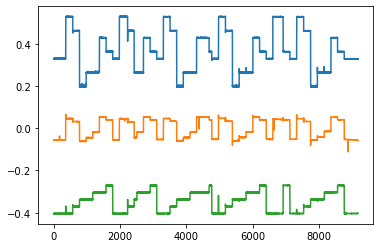

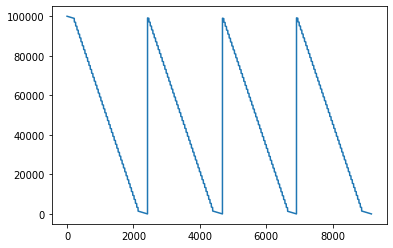

In [25]:
ii = 1;
pplot.plot(np.max(data['training_instances'][0][:,:,ii],1))
pplot.plot(np.mean(data['training_instances'][0][:,:,ii],1))
pplot.plot(np.min(data['training_instances'][0][:,:,ii],1))
pplot.show()
pplot.plot(data['training_instances'][1])

In [26]:
from IPython.display import clear_output
#epoch = 5
c_loss = 50;
def plot_cmatrix_strong_return_top3acc(leave_exp_out, epoch, c_loss,root_folder = "/tmp"):
    yyhat = model.predict(Xstrong)
    cmat = confusion_matrix(np.argmax(YstrongOH,1),np.argmax(yyhat[1],1))
    #cmat = cmat[0:-1,0:-1]
    crange = int(150000/15);
    target_names = ["%i<=Nr<%i"%((i)*crange,(i+1)*crange) for i in range(cmat.shape[0])]
    if epoch % 1 == 0:
        #clear_output()
        plot_confusion_matrix(cmat.eval(session = keras.backend.get_session()),
                              target_names = target_names , figsize = (10,10), normalize= False, title = "Confusion Matrix\nLeft out exp%s"%(leave_exp_out))
        pplot.show()
        #pplot.pause(0.1)
    
    #pplot.savefig(os.path.join(root_folder,"epoch_%03i_exp_%s_closs%f.png"%(epoch,leave_exp_out, c_loss)))
    
    return keras.metrics.top_k_categorical_accuracy(YstrongOH,yyhat[1], k=3).eval(session = keras.backend.get_session()), cmat


#top3acc_strong = plot_cmatrix_strong_return_top3acc(leave_exp_out, epoch, c_loss)

In [27]:
if False:
    ids_exp = [eid_vector_all == 'VA_1']
    yyhat = model.predict(X_all[ids_exp])
    cmat = confusion_matrix(np.argmax(Yoh_all[ids_exp],1),np.argmax(yyhat[1],1))
    crange = int(150000/15);
    target_names = ["%i<=Nr<%i"%((i)*crange,(i+1)*crange) for i in range(cmat.shape[0])]
    plot_confusion_matrix(cmat.eval(),target_names = target_names, figsize = (5,5), normalize = False, title = "cmat.")


In [28]:
def local_smooth_labels(yy, smoothing_filter = [1,8,1]):
    v = np.vstack([np.convolve(yy_,smoothing_filter,'same') for yy_ in yy])
    v = v / np.sum(v,1)[np.newaxis].T
    v[np.isnan(v)] = 0.1
    return v

local_smooth_labels(Ytrain)

array([[0. , 0.1, 0.8, ..., 0. , 0. , 0. ],
       [0. , 0. , 0. , ..., 0.1, 0. , 0. ],
       [0. , 0. , 0.1, ..., 0. , 0. , 0. ],
       ...,
       [0. , 0. , 0. , ..., 0.8, 0.1, 0. ],
       [0. , 0. , 0. , ..., 0. , 0. , 0. ],
       [0. , 0. , 0.1, ..., 0. , 0. , 0. ]])

## Making the generalized adversarial model:

In [29]:
from sklearn.decomposition import PCA
#tf.keras.Sequential()
def make_models():
    model = make_model(model_json)
    feature_out_layer = model.get_layer([l.name for l in model.layers if "global_average" in l.name][0])
    feature_extractor  = Model(inputs = model.inputs,outputs =  feature_out_layer.output)
    grad_rev_layer = model.get_layer([l.name for l in model.layers if 'grad_rev' in l.name][0])
    c0_task_output = keras.Sequential([Dense(100, activation = 'relu'), Dropout(rate = 0.2), Dense(np.unique(c0_0).shape[0])], name = "C0_task")(grad_rev_layer.output)
    c1_task_output = keras.Sequential([Dense(100,activation = 'relu'), Dropout(rate = 0.2), Dense(np.unique(c1_0).shape[0])],name = "C1_task")(grad_rev_layer.output)
    gen_adv_model  = Model(inputs = model.input, outputs= [model.output, c0_task_output, c1_task_output])
    return gen_adv_model, feature_extractor,c0_task_output,c1_task_output

gen_adv_model, feature_extractor,c0_task_output,c1_task_output = make_models()

def data_for_pca(feature_extractor_model_):
    eid_vector_color = (eid_vector_all_0 == 'VA_1') * 1 +(eid_vector_all_0 == 'VA_2') * 2 + (eid_vector_all_0 == 'VA_3') * 3 + (eid_vector_all_0 == 'VA_4') * 4
    #subsample_data_range_index = Y_classes
    #eid_vector_color
    eid_vector_color = eid_vector_color[Y_classes == 9]
    xpca = X_all_0[Y_classes == 9]
    yhat = feature_extractor_model_.predict(xpca);
    return yhat, eid_vector_color

a,b = data_for_pca(feature_extractor)
class plot_PCA(tf.keras.callbacks.Callback):
    def __init__(self, plot_directly = True, feature_extractor_model_ = feature_extractor):
        self.top3acc_strong = []
        self.plot_directly = plot_directly
        self.feature_extractor_model_ = feature_extractor
        
    def on_epoch_end(self,epoch,logs = None):
        a,b = data_for_pca(self.feature_extractor_model_)
        pp = PCA(n_components=2).fit_transform((a - np.mean(a,0)) /np.std(a))
        
        pplot.scatter(pp[:,0], pp[:,1],c = b)
        if self.plot_directly:
            pplot.show()
        #top3acc = plot_cmatrix_strong_return_top3acc(leave_exp_out, epoch, 0.001,root_folder = "/tmp")
#pp = plot_PCA()
#pp.on_epoch_end(epoch = 1)

{'inputs': [{'type': 'timeseries', 'help_string': '(required) the timeseries input for the layer.', 'id': 'timeseries_input', 'shape': (1500, 6)}], 'densenet_1d': {'network_layers': [{'type': 'densenet_block', 'id': 'DN1', 'help_string': 'Parametrization for a `densenet_block`', 'params': {'filters': [20, 20, 20, 20, 20], 'dilation_rates': [2, 4, 8, 16, 32, 64, 128, 512, 8, 16, 32, 64, 128, 512], 'kernel_sizes': [10, 10, 10, 10, 10], 'Variational': False}}, {'type': 'final_pooling', 'id': 'FinalPooling'}]}, 'domain_classifier': {'network_layers': [{'type': 'Dense', 'params': {'units': 100, 'activation': 'relu', 'use_bias': True}}, {'type': 'Dropout', 'params': {'rate': 0.2}}, {'type': 'Dense', 'id': 'domain_output', 'params': {'units': 4, 'name': 'ExpID'}}]}, 'classifier': {'network_layers': [{'type': 'Dense', 'params': {'units': 100, 'activation': 'relu', 'use_bias': True}}, {'type': 'Dropout', 'params': {'rate': 0.2}}, {'type': 'Dense', 'id': 'domain_output', 'params': {'units': 10, 

{'inputs': [{'type': 'timeseries', 'help_string': '(required) the timeseries input for the layer.', 'id': 'timeseries_input', 'shape': (1500, 6)}], 'densenet_1d': {'network_layers': [{'type': 'densenet_block', 'id': 'DN1', 'help_string': 'Parametrization for a `densenet_block`', 'params': {'filters': [20, 20, 20, 20, 20], 'dilation_rates': [2, 4, 8, 16, 32, 64, 128, 512, 8, 16, 32, 64, 128, 512], 'kernel_sizes': [10, 10, 10, 10, 10], 'Variational': False, 'internal_bottleneck_factor': 1, 'dropout_after_composite': None}}, {'type': 'final_pooling', 'id': 'FinalPooling'}]}, 'domain_classifier': {'network_layers': [{'type': 'Dense', 'params': {'units': 100, 'activation': 'relu', 'use_bias': True}}, {'type': 'Dropout', 'params': {'rate': 0.2}}, {'type': 'Dense', 'id': 'domain_output', 'params': {'units': 4, 'name': 'ExpID'}}]}, 'classifier': {'network_layers': [{'type': 'Dense', 'params': {'units': 100, 'activation': 'relu', 'use_bias': True}}, {'type': 'Dropout', 'params': {'rate': 0.2}},

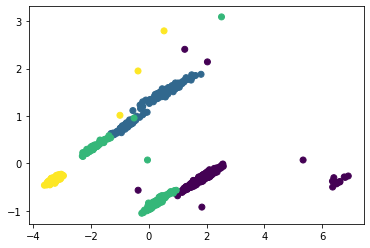

7335/7335 [==============================] - 18s 2ms/sample - loss: 2.7849 - ExpID_loss: 1.4072 - Y_output_loss: 2.2854 - C0_task_loss: 1.9461 - C1_task_loss: 1.6421 - Y_output_top3_acc: 0.3734 - val_loss: 2.7729 - val_ExpID_loss: 1.3984 - val_Y_output_loss: 2.2747 - val_C0_task_loss: 1.9461 - val_C1_task_loss: 1.6361 - val_Y_output_top3_acc: 0.3790
Epoch 2/30
7200/7335 [============================>.] - ETA: 0s - loss: 2.7860 - ExpID_loss: 1.4087 - Y_output_loss: 2.2862 - C0_task_loss: 1.9472 - C1_task_loss: 1.6418 - Y_output_top3_acc: 0.3656

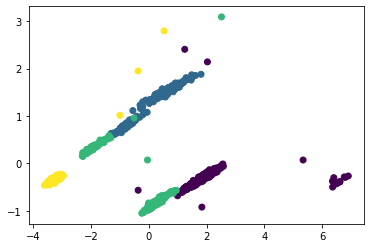

7335/7335 [==============================] - 10s 1ms/sample - loss: 2.7857 - ExpID_loss: 1.4089 - Y_output_loss: 2.2857 - C0_task_loss: 1.9472 - C1_task_loss: 1.6417 - Y_output_top3_acc: 0.3655 - val_loss: 2.7729 - val_ExpID_loss: 1.3984 - val_Y_output_loss: 2.2747 - val_C0_task_loss: 1.9461 - val_C1_task_loss: 1.6361 - val_Y_output_top3_acc: 0.3790
Epoch 3/30
7200/7335 [============================>.] - ETA: 0s - loss: 2.7537 - ExpID_loss: 1.3998 - Y_output_loss: 2.2621 - C0_task_loss: 1.9258 - C1_task_loss: 1.5910 - Y_output_top3_acc: 0.3800

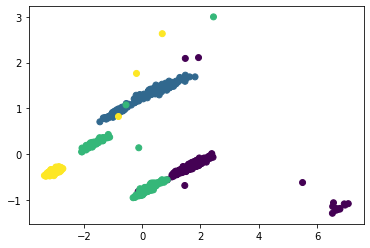

7335/7335 [==============================] - 10s 1ms/sample - loss: 2.7531 - ExpID_loss: 1.3998 - Y_output_loss: 2.2613 - C0_task_loss: 1.9250 - C1_task_loss: 1.5900 - Y_output_top3_acc: 0.3806 - val_loss: 2.7209 - val_ExpID_loss: 1.3867 - val_Y_output_loss: 2.2391 - val_C0_task_loss: 1.9104 - val_C1_task_loss: 1.5530 - val_Y_output_top3_acc: 0.4068
Epoch 4/30
7200/7335 [============================>.] - ETA: 0s - loss: 2.7306 - ExpID_loss: 1.3858 - Y_output_loss: 2.2495 - C0_task_loss: 1.8979 - C1_task_loss: 1.5278 - Y_output_top3_acc: 0.3899

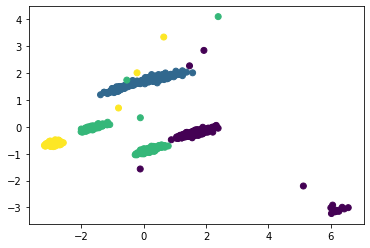

7335/7335 [==============================] - 10s 1ms/sample - loss: 2.7299 - ExpID_loss: 1.3854 - Y_output_loss: 2.2486 - C0_task_loss: 1.8974 - C1_task_loss: 1.5271 - Y_output_top3_acc: 0.3902 - val_loss: 2.6978 - val_ExpID_loss: 1.3834 - val_Y_output_loss: 2.2246 - val_C0_task_loss: 1.8816 - val_C1_task_loss: 1.5068 - val_Y_output_top3_acc: 0.4291
Epoch 5/30
7200/7335 [============================>.] - ETA: 0s - loss: 2.6919 - ExpID_loss: 1.3793 - Y_output_loss: 2.2219 - C0_task_loss: 1.8456 - C1_task_loss: 1.4747 - Y_output_top3_acc: 0.4146

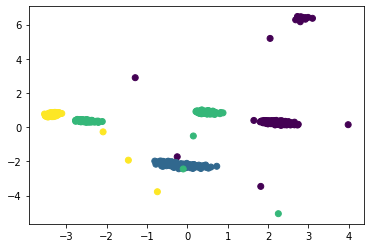

7335/7335 [==============================] - 10s 1ms/sample - loss: 2.6899 - ExpID_loss: 1.3790 - Y_output_loss: 2.2194 - C0_task_loss: 1.8441 - C1_task_loss: 1.4734 - Y_output_top3_acc: 0.4170 - val_loss: 2.6220 - val_ExpID_loss: 1.3715 - val_Y_output_loss: 2.1667 - val_C0_task_loss: 1.7883 - val_C1_task_loss: 1.4547 - val_Y_output_top3_acc: 0.4902
Epoch 6/30
7200/7335 [============================>.] - ETA: 0s - loss: 2.5775 - ExpID_loss: 1.3612 - Y_output_loss: 2.1393 - C0_task_loss: 1.6262 - C1_task_loss: 1.3950 - Y_output_top3_acc: 0.4960

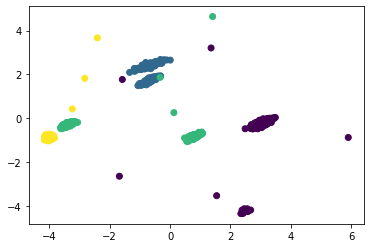

7335/7335 [==============================] - 10s 1ms/sample - loss: 2.5792 - ExpID_loss: 1.3607 - Y_output_loss: 2.1421 - C0_task_loss: 1.6234 - C1_task_loss: 1.3948 - Y_output_top3_acc: 0.4948 - val_loss: 2.4664 - val_ExpID_loss: 1.3348 - val_Y_output_loss: 2.0566 - val_C0_task_loss: 1.4693 - val_C1_task_loss: 1.3380 - val_Y_output_top3_acc: 0.5234
Epoch 7/30
7200/7335 [============================>.] - ETA: 0s - loss: 2.4822 - ExpID_loss: 1.3298 - Y_output_loss: 2.0728 - C0_task_loss: 1.4232 - C1_task_loss: 1.3416 - Y_output_top3_acc: 0.5268

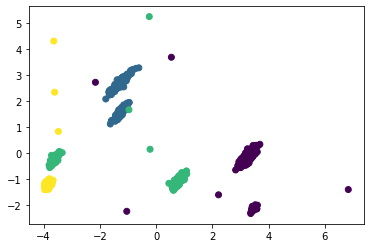

7335/7335 [==============================] - 10s 1ms/sample - loss: 2.4802 - ExpID_loss: 1.3290 - Y_output_loss: 2.0701 - C0_task_loss: 1.4208 - C1_task_loss: 1.3414 - Y_output_top3_acc: 0.5282 - val_loss: 2.3352 - val_ExpID_loss: 1.3090 - val_Y_output_loss: 1.9487 - val_C0_task_loss: 1.2991 - val_C1_task_loss: 1.3084 - val_Y_output_top3_acc: 0.5862
Epoch 8/30
7200/7335 [============================>.] - ETA: 0s - loss: 3.0131 - ExpID_loss: 1.5931 - Y_output_loss: 2.1862 - C0_task_loss: 3.6081 - C1_task_loss: 3.0675 - Y_output_top3_acc: 0.5257

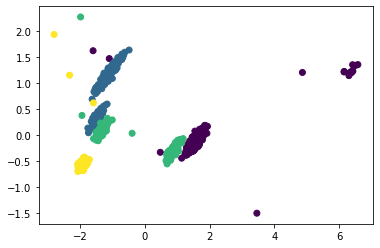

7335/7335 [==============================] - 10s 1ms/sample - loss: 3.0831 - ExpID_loss: 1.6297 - Y_output_loss: 2.2410 - C0_task_loss: 3.8793 - C1_task_loss: 3.2409 - Y_output_top3_acc: 0.5246 - val_loss: 4.9481 - val_ExpID_loss: 2.4675 - val_Y_output_loss: 3.1261 - val_C0_task_loss: 8.1505 - val_C1_task_loss: 7.7757 - val_Y_output_top3_acc: 0.3806
Epoch 9/30
7200/7335 [============================>.] - ETA: 0s - loss: 11.9660 - ExpID_loss: 8.5097 - Y_output_loss: 3.6335 - C0_task_loss: 51.0662 - C1_task_loss: 23.7491 - Y_output_top3_acc: 0.3533

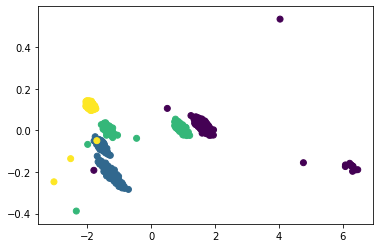

7335/7335 [==============================] - 10s 1ms/sample - loss: 12.0437 - ExpID_loss: 8.4750 - Y_output_loss: 3.5976 - C0_task_loss: 52.3384 - C1_task_loss: 24.0109 - Y_output_top3_acc: 0.3517 - val_loss: 13.0465 - val_ExpID_loss: 1.5538 - val_Y_output_loss: 2.3051 - val_C0_task_loss: 75.1968 - val_C1_task_loss: 29.3738 - val_Y_output_top3_acc: 0.2748
Epoch 10/30
7200/7335 [============================>.] - ETA: 0s - loss: 175.3326 - ExpID_loss: 296.6716 - Y_output_loss: 35.9461 - C0_task_loss: 635.6677 - C1_task_loss: 461.5258 - Y_output_top3_acc: 0.2969

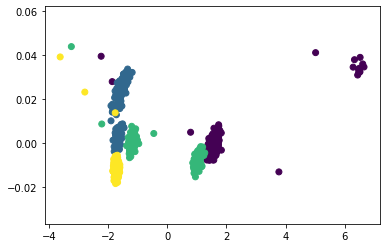

7335/7335 [==============================] - 10s 1ms/sample - loss: 172.3412 - ExpID_loss: 288.6909 - Y_output_loss: 35.0368 - C0_task_loss: 618.5403 - C1_task_loss: 451.7991 - Y_output_top3_acc: 0.2975 - val_loss: 2.7979 - val_ExpID_loss: 1.3865 - val_Y_output_loss: 2.3035 - val_C0_task_loss: 1.9448 - val_C1_task_loss: 1.6150 - val_Y_output_top3_acc: 0.2863
Epoch 11/30
7200/7335 [============================>.] - ETA: 0s - loss: 8.0403 - ExpID_loss: 5.6159 - Y_output_loss: 7.0777 - C0_task_loss: 1.9437 - C1_task_loss: 2.0657 - Y_output_top3_acc: 0.3214

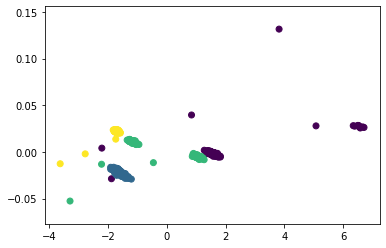

7335/7335 [==============================] - 10s 1ms/sample - loss: 7.9437 - ExpID_loss: 5.5016 - Y_output_loss: 6.9486 - C0_task_loss: 1.9437 - C1_task_loss: 2.0533 - Y_output_top3_acc: 0.3223 - val_loss: 7.0245 - val_ExpID_loss: 1.3862 - val_Y_output_loss: 2.2999 - val_C0_task_loss: 43.8989 - val_C1_task_loss: 1.6082 - val_Y_output_top3_acc: 0.3931
Epoch 12/30
7200/7335 [============================>.] - ETA: 0s - loss: 2.9052 - ExpID_loss: 1.3869 - Y_output_loss: 2.2987 - C0_task_loss: 3.0753 - C1_task_loss: 1.6028 - Y_output_top3_acc: 0.3887

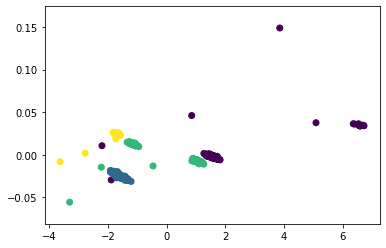

7335/7335 [==============================] - 10s 1ms/sample - loss: 2.9031 - ExpID_loss: 1.3869 - Y_output_loss: 2.2987 - C0_task_loss: 3.0446 - C1_task_loss: 1.6025 - Y_output_top3_acc: 0.3883 - val_loss: 2.7882 - val_ExpID_loss: 1.3861 - val_Y_output_loss: 2.2962 - val_C0_task_loss: 1.9386 - val_C1_task_loss: 1.5998 - val_Y_output_top3_acc: 0.3931
Epoch 13/30
7200/7335 [============================>.] - ETA: 0s - loss: 2.7874 - ExpID_loss: 1.3867 - Y_output_loss: 2.2957 - C0_task_loss: 1.9366 - C1_task_loss: 1.5940 - Y_output_top3_acc: 0.3867

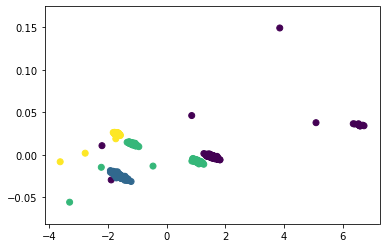

7335/7335 [==============================] - 10s 1ms/sample - loss: 2.7872 - ExpID_loss: 1.3867 - Y_output_loss: 2.2955 - C0_task_loss: 1.9362 - C1_task_loss: 1.5937 - Y_output_top3_acc: 0.3883 - val_loss: 2.7835 - val_ExpID_loss: 1.3861 - val_Y_output_loss: 2.2928 - val_C0_task_loss: 1.9354 - val_C1_task_loss: 1.5921 - val_Y_output_top3_acc: 0.3931
Epoch 14/30
7200/7335 [============================>.] - ETA: 0s - loss: 2.7832 - ExpID_loss: 1.3865 - Y_output_loss: 2.2927 - C0_task_loss: 1.9330 - C1_task_loss: 1.5860 - Y_output_top3_acc: 0.3881

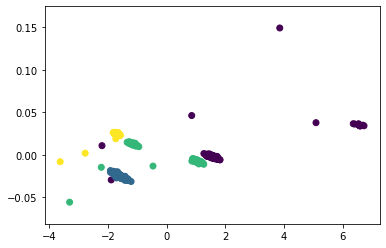

7335/7335 [==============================] - 10s 1ms/sample - loss: 2.7833 - ExpID_loss: 1.3865 - Y_output_loss: 2.2927 - C0_task_loss: 1.9330 - C1_task_loss: 1.5857 - Y_output_top3_acc: 0.3883 - val_loss: 2.7791 - val_ExpID_loss: 1.3861 - val_Y_output_loss: 2.2895 - val_C0_task_loss: 1.9324 - val_C1_task_loss: 1.5851 - val_Y_output_top3_acc: 0.3931
Epoch 15/30
7200/7335 [============================>.] - ETA: 0s - loss: 2.7796 - ExpID_loss: 1.3864 - Y_output_loss: 2.2901 - C0_task_loss: 1.9298 - C1_task_loss: 1.5785 - Y_output_top3_acc: 0.3904

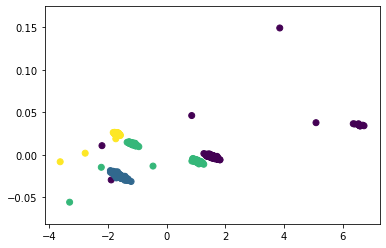

7335/7335 [==============================] - 10s 1ms/sample - loss: 2.7795 - ExpID_loss: 1.3863 - Y_output_loss: 2.2900 - C0_task_loss: 1.9300 - C1_task_loss: 1.5785 - Y_output_top3_acc: 0.3898 - val_loss: 2.7752 - val_ExpID_loss: 1.3861 - val_Y_output_loss: 2.2867 - val_C0_task_loss: 1.9298 - val_C1_task_loss: 1.5788 - val_Y_output_top3_acc: 0.3915
Epoch 16/30
7200/7335 [============================>.] - ETA: 0s - loss: 2.7761 - ExpID_loss: 1.3862 - Y_output_loss: 2.2875 - C0_task_loss: 1.9274 - C1_task_loss: 1.5721 - Y_output_top3_acc: 0.3897

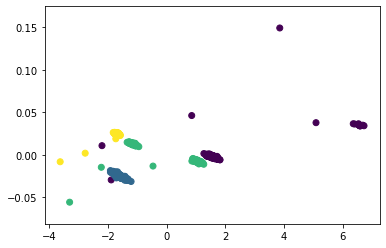

7335/7335 [==============================] - 10s 1ms/sample - loss: 2.7762 - ExpID_loss: 1.3862 - Y_output_loss: 2.2878 - C0_task_loss: 1.9270 - C1_task_loss: 1.5717 - Y_output_top3_acc: 0.3887 - val_loss: 2.7716 - val_ExpID_loss: 1.3861 - val_Y_output_loss: 2.2840 - val_C0_task_loss: 1.9275 - val_C1_task_loss: 1.5732 - val_Y_output_top3_acc: 0.3915
Epoch 17/30
7200/7335 [============================>.] - ETA: 0s - loss: 2.7732 - ExpID_loss: 1.3861 - Y_output_loss: 2.2855 - C0_task_loss: 1.9248 - C1_task_loss: 1.5661 - Y_output_top3_acc: 0.3889Restoring model weights from the end of the best epoch.


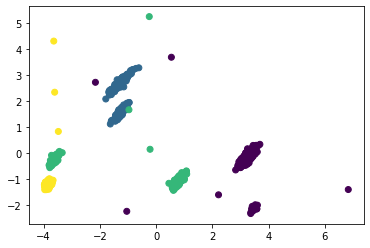

7335/7335 [==============================] - 10s 1ms/sample - loss: 2.7732 - ExpID_loss: 1.3861 - Y_output_loss: 2.2856 - C0_task_loss: 1.9246 - C1_task_loss: 1.5657 - Y_output_top3_acc: 0.3887 - val_loss: 2.7682 - val_ExpID_loss: 1.3861 - val_Y_output_loss: 2.2815 - val_C0_task_loss: 1.9253 - val_C1_task_loss: 1.5679 - val_Y_output_top3_acc: 0.3915
Epoch 00017: early stopping
Instructions for updating:
If using Keras pass *_constraint arguments to layers.


FailedPreconditionError: model_closs0.10/variables; Not a directory

In [32]:
confusion_matrix = tf.math.confusion_matrix
epochs = 30; #training_parameters["nepochs"]
batchsize =200;

#from tensorflow import confusion_matrix

import tensorflow.keras as keras
from tensorflow.keras import layers 
#lrate = 0.001

LRATE_MAX = 0.001;
BURNIN_EPOCHS = 10;

c_loss =0.0;
CLOSS_MAX = 0.1;

closs_variable = keras.backend.variable(1.)

es = keras.callbacks.EarlyStopping(monitor='val_Y_output_loss', mode='min', verbose=1, patience=10, restore_best_weights = True)
model_opt = keras.optimizers.Adam(learning_rate=0.0);



class Top3AccStrong(tf.keras.callbacks.Callback):
    def __init__(self):
        self.top3acc_strong = []
    def on_epoch_end(self,epoch,logs = None):
        if (epoch+1) % 10 == 0:
            None
            #top3acc, cmatrix_strong = plot_cmatrix_strong_return_top3acc(leave_exp_out, epoch, 0.001,root_folder = "/tmp")
            #self.top3acc_strong.append(top3acc)


class BurnIn(tf.keras.callbacks.Callback):
    def __init__(self, model_opt_, burnin_epochs = None, lrate_max = LRATE_MAX):
        self.learning_rate = lrate_max
        self.burnin_epochs = burnin_epochs
        self.model_opt = model_opt_
        
    def on_epoch_end(self,epoch, logs = None):
        if epoch <= self.burnin_epochs:
            de = epoch/self.burnin_epochs
            self.model_opt.learning_rate = de * self.learning_rate
        else:
            None

def top3_acc(labels, logits):
    return keras.metrics.top_k_categorical_accuracy(labels,logits, k=3)


def plot_confusion():
    cmat = confusion_matrix(np.argmax(Yoh,1),np.argmax(Yhat,1))
    pplot.pcolor(cmat.eval())
    pplot.show()


loss_fcn = {"Y_output" :tf.compat.v1.losses.softmax_cross_entropy,
            "ExpID" : lambda y,yhat : tf.compat.v1.losses.softmax_cross_entropy(y,yhat),
            "C0_task" : lambda y,yhat : tf.compat.v1.losses.softmax_cross_entropy(y,yhat),
            "C1_task" : lambda y,yhat : tf.compat.v1.losses.softmax_cross_entropy(y,yhat),
           }

for c_loss in [0.10,0.20,0.30 ]:
    gen_adv_model, feature_extractor,c0_task_output,c1_task_output = make_models()
    
    loss_w = {"Y_output": 1.,"ExpID" : c_loss , "C0_task": c_loss,"C1_task": c_loss }

    # GOAL: Minimize the useless discriminator while maximizing the useful classifier.

    # useful discriminator:
    gen_adv_model.compile(optimizer =  model_opt,
                  loss =loss_fcn,
                  loss_weights = loss_w,
                  metrics = {"Y_output" : top3_acc})

    train_in, train_out = [{"timeseries_input": Xtrain},{"Y_output":local_smooth_labels(Ytrain),
                                                         "ExpID" : EIDTrain, "C0_task" : coh_0_train, "C1_task" : coh_1_train}]
    test_in, test_out = [{"timeseries_input" : Xtest}, {"Y_output" : Ytest, "ExpID" : EIDTest,
                                                        "C0_task" : coh_0_test, "C1_task" : coh_1_test}]
    # I use the left-out experiment as validation set. 
    # The only info used from the left-out set is when to stop training.
    # Results are good also by using a validation set from the "seen" experiments.
    #test_in, test_out = [{"timeseries_input" : Xstrong}, {"Y_output" : YstrongOH, "ExpID" : np.zeros([YstrongOH.shape[0],3])}]
    burnin = BurnIn(model_opt_ = model_opt,burnin_epochs = BURNIN_EPOCHS, lrate_max = LRATE_MAX)
    history_d = gen_adv_model.fit(train_in, train_out, epochs=epochs,
                         batch_size=batchsize,
                          validation_data = [test_in, test_out],# "Rc_output" :  RemCTest}],
                         callbacks=[es, burnin,Top3AccStrong(), plot_PCA()])#, Top3AccStrong()])#, InspectActivations()]);#, Top3AccStrong()])

    gen_adv_model.save("model_closs%2.2f"%c_loss)
# history_d_more = [];
# ncycles = 100
# for kk in range(ncycles):
    
#     closs_variable = (CLOSS_MAX * kk)/ncycles
#     loss_w = {"Y_output": 1,"ExpID" : closs_variable , "C0_task": closs_variable,"C1_task": closs_variable }
    
#     gen_adv_model.compile(optimizer =  model_opt,
#           loss =loss_fcn,
#           loss_weights = loss_w,
#           metrics = {"Y_output" : top3_acc})

#     history_d_more.append(gen_adv_model.fit(train_in, train_out, epochs=1,
#                          batch_size=batchsize,
#                           validation_data = [test_in, test_out],callbacks=[es,plot_PCA()]))

#     print("step improving generalization:")
#     closs_variable = 0.
#     loss_w = {"Y_output": 1,"ExpID" : closs_variable , "C0_task": closs_variable,"C1_task": closs_variable }
#     history_d_more.append(gen_adv_model.fit(train_in, train_out, epochs=1,
#                          batch_size=batchsize,
#                           validation_data = [test_in, test_out],callbacks=[es,plot_PCA()]))




In [36]:
#gen_adv_model.save("model_closs0.00")
#m = gen_adv_model.load_weights("model_closs0.00")
gen_adv_model, feature_extractor,c0_task_output,c1_task_output = make_models()

{'inputs': [{'type': 'timeseries', 'help_string': '(required) the timeseries input for the layer.', 'id': 'timeseries_input', 'shape': (1500, 6)}], 'densenet_1d': {'network_layers': [{'type': 'densenet_block', 'id': 'DN1', 'help_string': 'Parametrization for a `densenet_block`', 'params': {'filters': [20, 20, 20, 20, 20], 'dilation_rates': [2, 4, 8, 16, 32, 64, 128, 512, 8, 16, 32, 64, 128, 512], 'kernel_sizes': [10, 10, 10, 10, 10], 'Variational': False, 'internal_bottleneck_factor': 1, 'dropout_after_composite': None}}, {'type': 'final_pooling', 'id': 'FinalPooling'}]}, 'domain_classifier': {'network_layers': [{'type': 'Dense', 'params': {'units': 100, 'activation': 'relu', 'use_bias': True}}, {'type': 'Dropout', 'params': {'rate': 0.2}}, {'type': 'Dense', 'id': 'domain_output', 'params': {'units': 4, 'name': 'ExpID'}}]}, 'classifier': {'network_layers': [{'type': 'Dense', 'params': {'units': 100, 'activation': 'relu', 'use_bias': True}}, {'type': 'Dropout', 'params': {'rate': 0.2}},

In [37]:

# def col_norm(xx):
#     for ii in range(5):
#         xx[:,:,ii] = (xx[:,:,ii].T + abs(np.min(xx[:,:,ii],-1))).T
#         xx[:,:,ii] = (xx[:,:,ii].T / abs(np.max(xx[:,:,ii],-1))).T
#     return xx

# eid1 = eid_vector_all_0 == 'VA_1';
# eid2 = eid_vector_all_0 == 'VA_2';
# xeid1 = col_norm(X_all_0[eid1])
# xeid2 = col_norm(X_all_0[eid2])
# ii = 6 ;
# pplot.plot(np.min(xeid1[:,:,ii],-1),'ob')
# pplot.plot(np.max(xeid1[:,:,ii],-1),'ob')
# pplot.plot(np.min(xeid2[:,:,ii],-1),'xr')
# pplot.plot(np.max(xeid2[:,:,ii],-1),'xr')



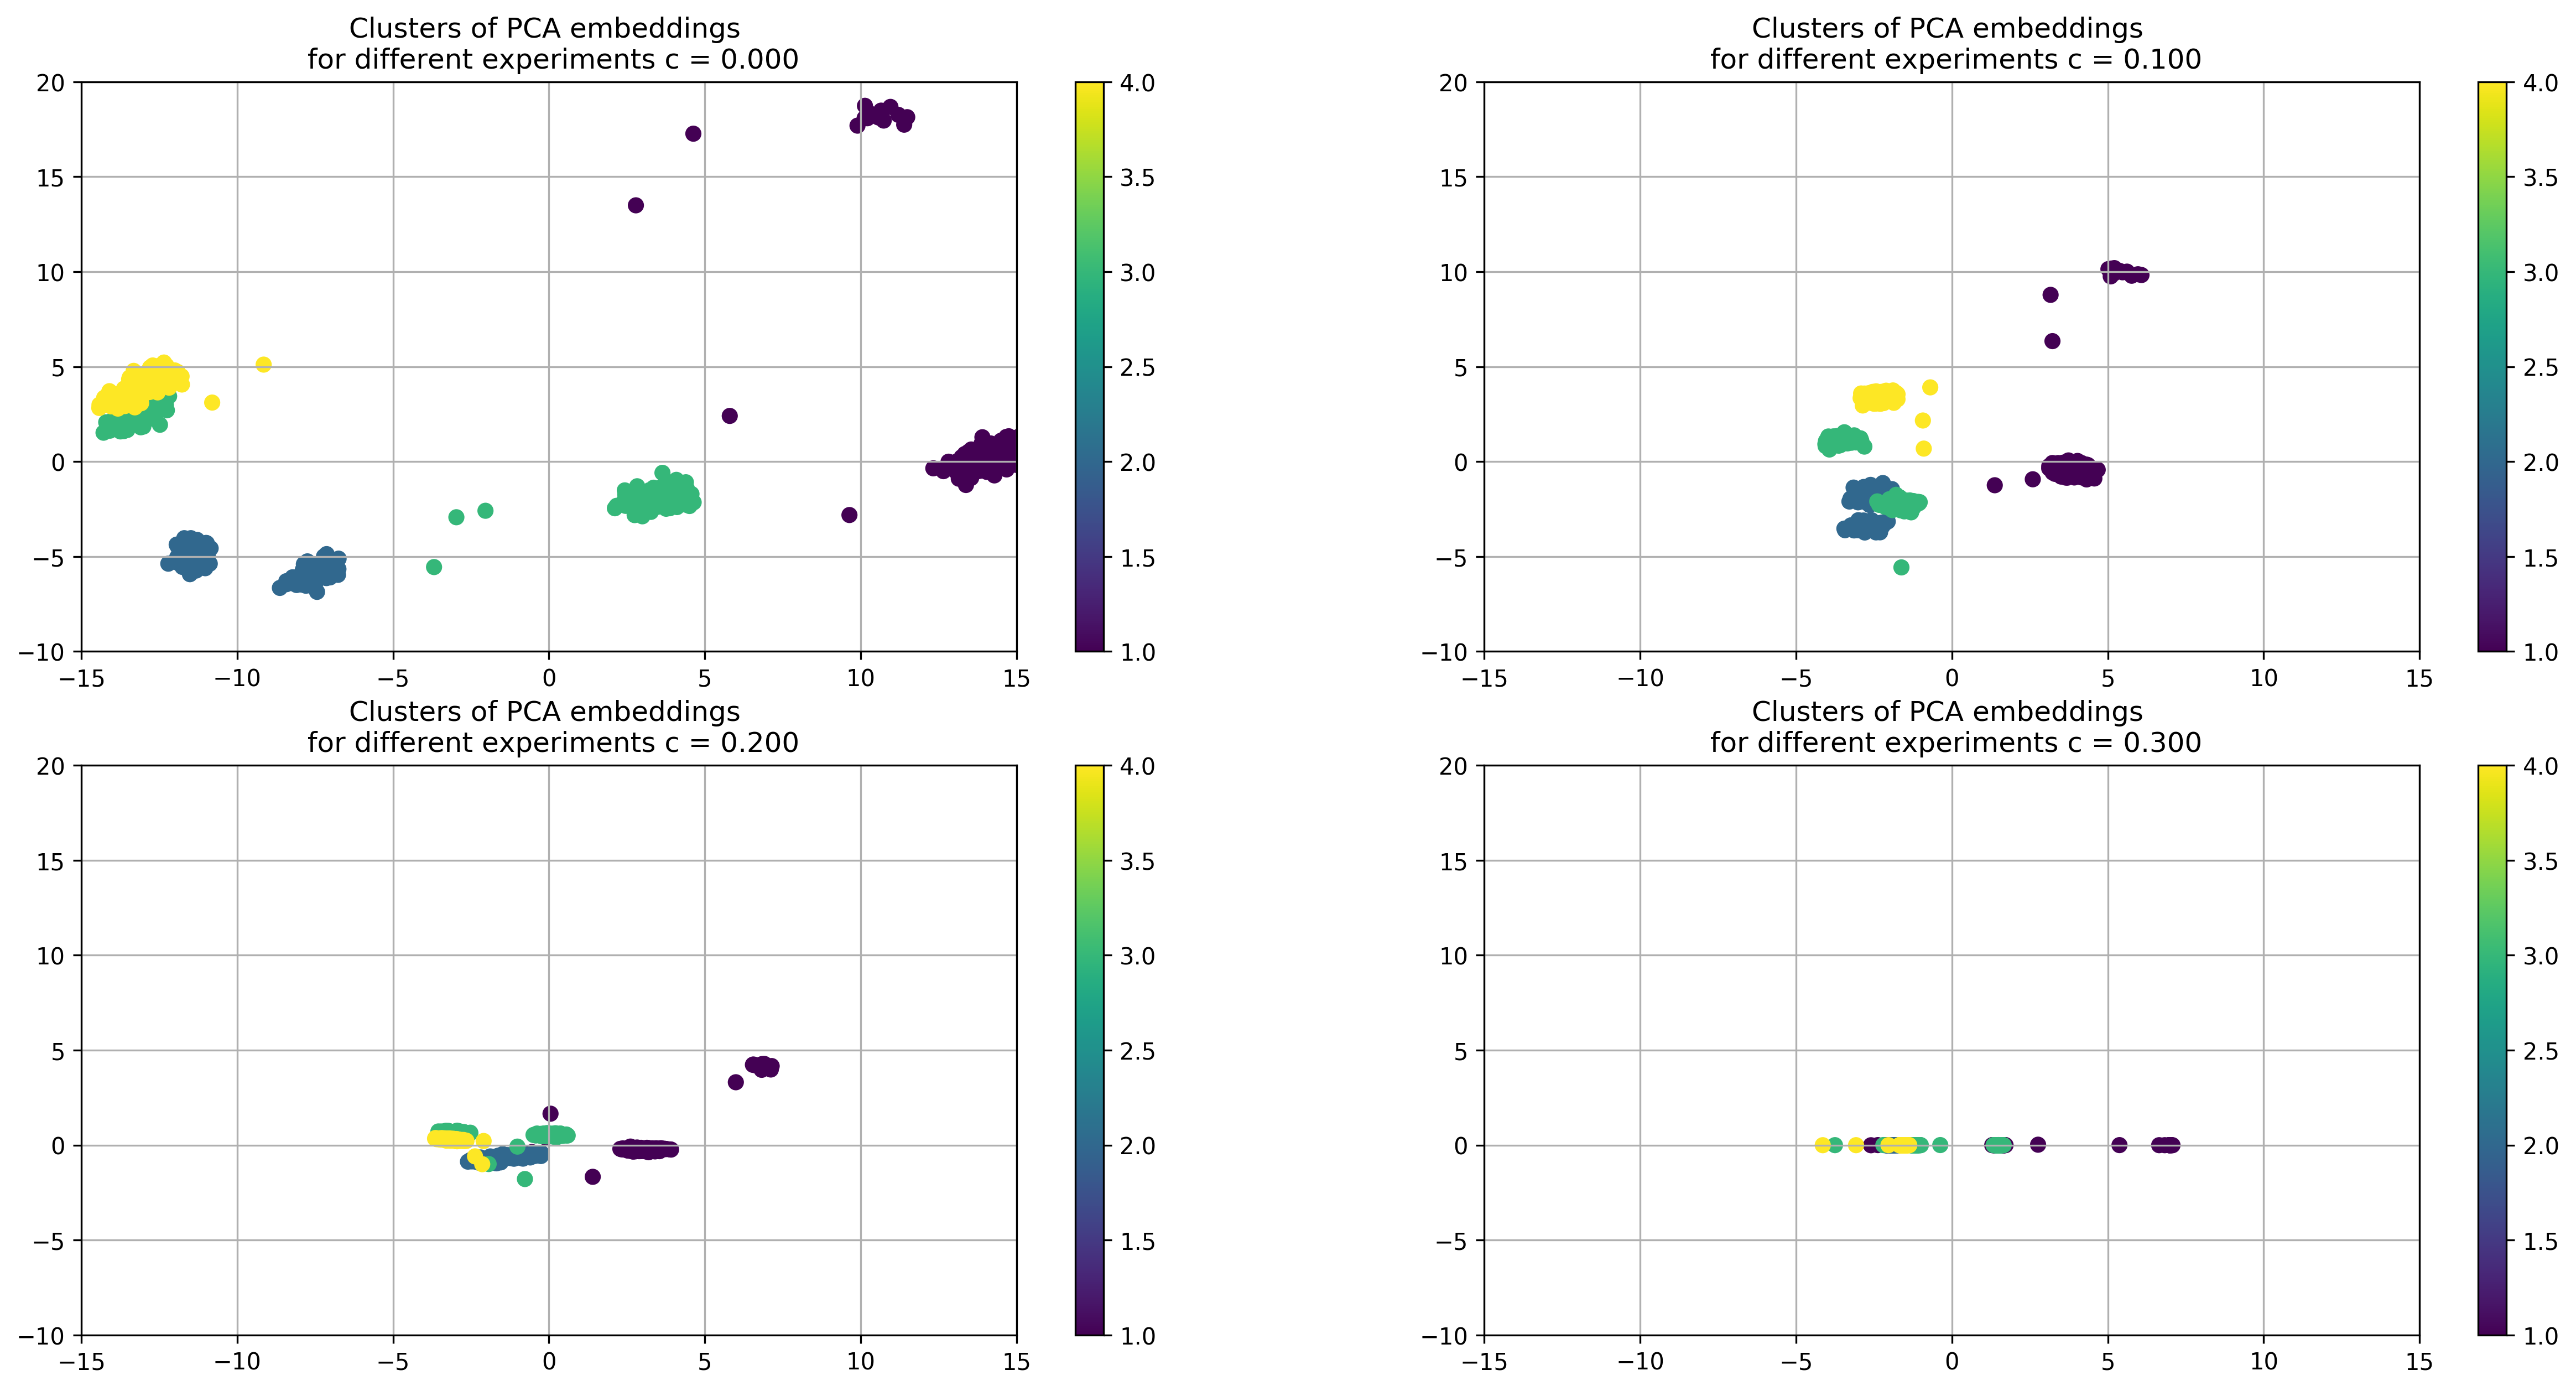

In [38]:
pplot.figure(figsize = (20,10), dpi = 300);

for kk,closs_ in enumerate([0, 0.1, 0.2, 0.3]):
    gen_adv_model.load_weights("model_closs%2.2f"%closs_)
    
    pplot.subplot(2,2,kk+1)
    pca_plot = plot_PCA(plot_directly = False, feature_extractor_model_= feature_extractor )

    pca_plot.on_epoch_end(epoch = 0)
    #pplot.grid()
    #pplot.title("With a c=0.05")
    pplot.colorbar()
    pplot.grid()
    pplot.xlim([-15,15])
    pplot.ylim([-10,20])
    
    pplot.title("Clusters of PCA embeddings \n for different experiments c = %2.3f"%closs_)
    

# *-*-*--**-*-*-*--*-*--*-*-*-8423542587f32ws84rf256s406f54s05e4rf05ws4erf25wse47rc25se4rc256s4erc25s4ercv0s5e4c0s5e4c













.










.
.










.
.










.
.










.
.










.
.










.




In [39]:
import tensorflow as tf
#tf.enable_eager_execution()
import tensorflow.keras as keras
import numpy as np
import matplotlib.pyplot as pplot
from tensorflow.keras import Model
from tensorflow.keras.layers import Input, Dense, Conv1D, AveragePooling1D, GlobalAveragePooling1D, Flatten, BatchNormalization, Dropout
from sklearn.decomposition import PCA

import os

from tensorflow.compat.v1 import ConfigProto
from tensorflow.compat.v1 import InteractiveSession
config = ConfigProto()
config.gpu_options.allow_growth = True
sess = InteractiveSession(config=config)
tf.keras.backend.set_session(sess)
from tensorflow.math import confusion_matrix
from src.dilated_densenet_adversarial import make_model, make_densenet_parametrization_dictionary

AttributeError: module 'tensorflow_core.keras.backend' has no attribute 'set_session'

In [40]:
%load_ext autoreload
%autoreload 
from src.util import plot_confusion_matrix
from src.experiments_utils import *

ndn = 5
ndn2 = 5

experiment_parametrization = {
    'dilation_rates_dn1': [2,4,8,16,32,64,128,512,8,16,32,64,128,512],#,4,8,16,32],
    'kernel_sizes_dn1' :  [10] * ndn,#,5,5],
    'nfilters_dn1' :  [20]*ndn,
    'dilation_rates_dn2' : [4]*ndn2,
    'kernel_sizes_dn2' : [5]*ndn2,
    'nfilters_dn2': [10]*ndn2
}

make_network_description_experiments_A(**experiment_parametrization)
model_json = make_network_json_experiments_A(**experiment_parametrization)

model_json["classifier"]["network_layers"][-1]['params']['units'] = 10
model_json["densenet_1d"]["network_layers"][0]["params"]["Variational"] = False
model_json["densenet_1d"]["network_layers"] = [
    model_json["densenet_1d"]["network_layers"][0],model_json["densenet_1d"]["network_layers"][-1]
]
model_json['inputs'][0]['shape'] = (1500,6)
model_json['domain_classifier']['network_layers'][-1]['params']['units'] = 4;

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [41]:

# I need a couple of more stuff I need to reg. against
DA2_0 = np.max(X_all_0[:,:,1],-1)
DA3_0 = np.min(X_all_0[:,:,0],-1)
q0 = np.quantile(DA2_0,np.linspace(0,1,400))
q1=np.quantile(DA3_0,np.linspace(0,1,400))
#pplot.plot(q1,'.')
qs0 = [0.25,0.30,0.35,0.40,0.45,0.50]
qs1 = [-0.38,-0.35,-0.32,-0.28]

c0_0 = np.zeros_like(DA2_0);
c1_0 = np.zeros_like(DA3_0);
for qq0 in qs0:
    c0_0 = c0_0 +  (DA2_0<qq0) * 1
    
for qs1 in qs1:
    c1_0 = c1_0 +  (DA3_0<qs1) * 1
c0_0_oh = tf.one_hot(c0_0,np.unique(c0_0).shape[0]).eval()
c1_0_oh = tf.one_hot(c1_0,np.unique(c1_0).shape[0]).eval()

NotFoundError: Could not find valid device for node.
Node:{{node OneHot}}
All kernels registered for op OneHot :
  device='XLA_CPU'; TI in [DT_INT32, DT_UINT8, DT_INT64]; T in [DT_FLOAT, DT_DOUBLE, DT_INT32, DT_UINT8, DT_INT16, ..., DT_UINT16, DT_COMPLEX128, DT_HALF, DT_UINT32, DT_UINT64]
  device='XLA_CPU_JIT'; TI in [DT_INT32, DT_UINT8, DT_INT64]; T in [DT_FLOAT, DT_DOUBLE, DT_INT32, DT_UINT8, DT_INT16, ..., DT_UINT16, DT_COMPLEX128, DT_HALF, DT_UINT32, DT_UINT64]
  device='XLA_GPU_JIT'; TI in [DT_INT32, DT_UINT8, DT_INT64]; T in [DT_FLOAT, DT_DOUBLE, DT_INT32, DT_UINT8, DT_INT16, ..., DT_UINT16, DT_COMPLEX128, DT_HALF, DT_UINT32, DT_UINT64]
  device='CPU'; TI in [DT_INT64]; T in [DT_VARIANT]
  device='CPU'; TI in [DT_INT32]; T in [DT_VARIANT]
  device='CPU'; TI in [DT_UINT8]; T in [DT_VARIANT]
  device='CPU'; TI in [DT_INT64]; T in [DT_RESOURCE]
  device='CPU'; TI in [DT_INT32]; T in [DT_RESOURCE]
  device='CPU'; TI in [DT_UINT8]; T in [DT_RESOURCE]
  device='CPU'; TI in [DT_INT64]; T in [DT_STRING]
  device='CPU'; TI in [DT_INT32]; T in [DT_STRING]
  device='CPU'; TI in [DT_UINT8]; T in [DT_STRING]
  device='CPU'; TI in [DT_INT64]; T in [DT_BOOL]
  device='CPU'; TI in [DT_INT32]; T in [DT_BOOL]
  device='CPU'; TI in [DT_UINT8]; T in [DT_BOOL]
  device='CPU'; TI in [DT_INT64]; T in [DT_COMPLEX128]
  device='CPU'; TI in [DT_INT32]; T in [DT_COMPLEX128]
  device='CPU'; TI in [DT_UINT8]; T in [DT_COMPLEX128]
  device='CPU'; TI in [DT_INT64]; T in [DT_COMPLEX64]
  device='CPU'; TI in [DT_INT32]; T in [DT_COMPLEX64]
  device='CPU'; TI in [DT_UINT8]; T in [DT_COMPLEX64]
  device='CPU'; TI in [DT_INT64]; T in [DT_DOUBLE]
  device='CPU'; TI in [DT_INT32]; T in [DT_DOUBLE]
  device='CPU'; TI in [DT_UINT8]; T in [DT_DOUBLE]
  device='CPU'; TI in [DT_INT64]; T in [DT_FLOAT]
  device='CPU'; TI in [DT_INT32]; T in [DT_FLOAT]
  device='CPU'; TI in [DT_UINT8]; T in [DT_FLOAT]
  device='CPU'; TI in [DT_INT64]; T in [DT_BFLOAT16]
  device='CPU'; TI in [DT_INT32]; T in [DT_BFLOAT16]
  device='CPU'; TI in [DT_UINT8]; T in [DT_BFLOAT16]
  device='CPU'; TI in [DT_INT64]; T in [DT_HALF]
  device='CPU'; TI in [DT_INT32]; T in [DT_HALF]
  device='CPU'; TI in [DT_UINT8]; T in [DT_HALF]
  device='CPU'; TI in [DT_INT64]; T in [DT_INT8]
  device='CPU'; TI in [DT_INT32]; T in [DT_INT8]
  device='CPU'; TI in [DT_UINT8]; T in [DT_INT8]
  device='CPU'; TI in [DT_INT64]; T in [DT_UINT8]
  device='CPU'; TI in [DT_INT32]; T in [DT_UINT8]
  device='CPU'; TI in [DT_UINT8]; T in [DT_UINT8]
  device='CPU'; TI in [DT_INT64]; T in [DT_INT16]
  device='CPU'; TI in [DT_INT32]; T in [DT_INT16]
  device='CPU'; TI in [DT_UINT8]; T in [DT_INT16]
  device='CPU'; TI in [DT_INT64]; T in [DT_UINT16]
  device='CPU'; TI in [DT_INT32]; T in [DT_UINT16]
  device='CPU'; TI in [DT_UINT8]; T in [DT_UINT16]
  device='CPU'; TI in [DT_INT64]; T in [DT_INT32]
  device='CPU'; TI in [DT_INT32]; T in [DT_INT32]
  device='CPU'; TI in [DT_UINT8]; T in [DT_INT32]
  device='CPU'; TI in [DT_INT64]; T in [DT_INT64]
  device='CPU'; TI in [DT_INT32]; T in [DT_INT64]
  device='CPU'; TI in [DT_UINT8]; T in [DT_INT64]
  device='GPU'; TI in [DT_INT64]; T in [DT_INT64]
  device='GPU'; TI in [DT_INT32]; T in [DT_INT64]
  device='GPU'; TI in [DT_UINT8]; T in [DT_INT64]
  device='GPU'; TI in [DT_INT64]; T in [DT_INT32]
  device='GPU'; TI in [DT_INT32]; T in [DT_INT32]
  device='GPU'; TI in [DT_UINT8]; T in [DT_INT32]
  device='GPU'; TI in [DT_INT64]; T in [DT_BOOL]
  device='GPU'; TI in [DT_INT32]; T in [DT_BOOL]
  device='GPU'; TI in [DT_UINT8]; T in [DT_BOOL]
  device='GPU'; TI in [DT_INT64]; T in [DT_DOUBLE]
  device='GPU'; TI in [DT_INT32]; T in [DT_DOUBLE]
  device='GPU'; TI in [DT_UINT8]; T in [DT_DOUBLE]
  device='GPU'; TI in [DT_INT64]; T in [DT_FLOAT]
  device='GPU'; TI in [DT_INT32]; T in [DT_FLOAT]
  device='GPU'; TI in [DT_UINT8]; T in [DT_FLOAT]
  device='GPU'; TI in [DT_INT64]; T in [DT_HALF]
  device='GPU'; TI in [DT_INT32]; T in [DT_HALF]
  device='GPU'; TI in [DT_UINT8]; T in [DT_HALF]
  device='XLA_GPU'; TI in [DT_INT32, DT_UINT8, DT_INT64]; T in [DT_FLOAT, DT_DOUBLE, DT_INT32, DT_UINT8, DT_INT16, ..., DT_UINT16, DT_COMPLEX128, DT_HALF, DT_UINT32, DT_UINT64]
 [Op:OneHot] name: one_hot/

In [42]:
from sklearn.decomposition import PCA
#tf.keras.Sequential()
def make_models():
    model = make_model(model_json)
    feature_out_layer = model.get_layer([l.name for l in model.layers if "global_average" in l.name][0])
    feature_extractor  = Model(inputs = model.inputs,outputs =  feature_out_layer.output)
    grad_rev_layer = model.get_layer([l.name for l in model.layers if 'grad_rev' in l.name][0])
    c0_task_output = keras.Sequential([Dense(100, activation = 'relu'), Dropout(rate = 0.2), Dense(6)], name = "C0_task")(grad_rev_layer.output)
    c1_task_output = keras.Sequential([Dense(100,activation = 'relu'), Dropout(rate = 0.2), Dense(4)],name = "C1_task")(grad_rev_layer.output)
    gen_adv_model  = Model(inputs = model.input, outputs= [model.output, c0_task_output, c1_task_output])
    return gen_adv_model, feature_extractor,c0_task_output,c1_task_output

gen_adv_model, feature_extractor,c0_task_output,c1_task_output = make_models()

            

{'inputs': [{'type': 'timeseries', 'help_string': '(required) the timeseries input for the layer.', 'id': 'timeseries_input', 'shape': (1500, 6)}], 'densenet_1d': {'network_layers': [{'type': 'densenet_block', 'id': 'DN1', 'help_string': 'Parametrization for a `densenet_block`', 'params': {'filters': [20, 20, 20, 20, 20], 'dilation_rates': [2, 4, 8, 16, 32, 64, 128, 512, 8, 16, 32, 64, 128, 512], 'kernel_sizes': [10, 10, 10, 10, 10], 'Variational': False}}, {'type': 'final_pooling', 'id': 'FinalPooling'}]}, 'domain_classifier': {'network_layers': [{'type': 'Dense', 'params': {'units': 100, 'activation': 'relu', 'use_bias': True}}, {'type': 'Dropout', 'params': {'rate': 0.2}}, {'type': 'Dense', 'id': 'domain_output', 'params': {'units': 4, 'name': 'ExpID'}}]}, 'classifier': {'network_layers': [{'type': 'Dense', 'params': {'units': 100, 'activation': 'relu', 'use_bias': True}}, {'type': 'Dropout', 'params': {'rate': 0.2}}, {'type': 'Dense', 'id': 'domain_output', 'params': {'units': 10, 

In [48]:
gen_adv_model.summary()

Model: "model_11"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
timeseries_input (InputLayer)   [(None, 1500, 6)]    0                                            
__________________________________________________________________________________________________
DN_DN1_C1D (Conv1D)             (None, 1500, 20)     140         timeseries_input[0][0]           
__________________________________________________________________________________________________
DN_DN1_idx_0 (Sequential)       (None, 1500, 20)     4440        DN_DN1_C1D[0][0]                 
__________________________________________________________________________________________________
DN_DN1_idx_1 (Sequential)       (None, 1500, 20)     4440        DN_DN1_idx_0[0][0]               
                                                                 DN_DN1_C1D[0][0]          

In [43]:
from src.util import load_hilti_fatigue_data, digitize
def load_hilti_fatigue_data(keep_from_end = 150000,    n_cycles_per_sub_block = 5, n_resampled = 300,nclasses = 15, leave_exp_out = 'VA_2', stage_2_from_disk = False,user_normalization = None, use_ds = None):

    #keep_from_end = 150000;
    #nclasses = 15
    if use_ds is None:
        use_ds = [1,2,3,4]
    
    if stage_2_from_disk:
        #keep_from_end = 300000;

        for kk_ , ds_idx in enumerate(use_ds):
            print("proc:"+str(ds_idx))
            ds =pd.read_pickle("csv/subs_200k_200/subs_csvs/VA_test{}_stage_2.pickle".format(ds_idx))
            ds.reset_index(inplace = True)
            remc = (ds.Zyklen.max() - ds.Zyklen)

            ds = ds[remc<=keep_from_end]
            ds['RemCycles'] = remc
            ds['ExpId'] = "VA_%i"%ds_idx
            if kk_ == 0:
                dataset = ds
            else:
                dataset = pd.concat([dataset,ds])


        def make_block_id_column(x):
            block_id = np.cumsum(np.hstack([True,np.diff(x.Zyklen.values)>1]))
            x['BlockId'] = block_id
            return x

        #n_resampled = 300 # uniform re-sampling per cycle.

        d = dataset.groupby("ExpId").apply(make_block_id_column)
    else:
        d = pd.read_csv("csv/subs_200k_200/subs_dataframe_{}k_from_end".format(int(keep_from_end/1000)))

    ######################################################################################################
    #n_resampled = 300

    def make_data_per_block(x):
        # This loses some cycles from the end.
        # This function should not perform normalization because there will be information leakage.
        # The only exception are accelerations. There is a weird shift in the accelerations which 
        # could be from static electricity or sth. It was decided to remove it here (just mean centering 
        # - this should not cause information leakage).
        n_stop_idx = x.shape[0] - (x.shape[0] % (n_resampled*n_cycles_per_sub_block))
        x = x[0:n_stop_idx]

        n_cycles_in_block = int(x.shape[0]/ n_resampled)
        shape_ = [n_cycles_in_block,int(x.shape[0]/n_cycles_in_block)]

        tangent_stiffness = x['KraftQ']/(x['WegQ']**0.15+ 0.1)
        tangent_stiffness = tangent_stiffness.values.reshape(shape_)
        f = x['KraftQ'].values.reshape(shape_)
        u = x['WegQ'].values.reshape(shape_)
        kdot = x['Kdot'].values.reshape(shape_)
        accel = x['AccelQ'].values.reshape(shape_)
        wdot = x['Wdot'].values.reshape(shape_)
        accel = accel - np.mean(accel)
        vals_dat = np.dstack([tangent_stiffness, f, u, accel, kdot, wdot])
        vals_dat = vals_dat.reshape([-1,n_cycles_per_sub_block*n_resampled,vals_dat.shape[-1]])

        get_scalar = lambda scname, x : x[scname].values.reshape(shape_).reshape([-1,n_cycles_per_sub_block*300])[:,0]

        rem_c_dat = get_scalar('RemCycles', x)
        #rem_c_dat = rem_c_dat.reshape([-1, n_cycles_per_sub_block])

        eid = get_scalar('ExpId',x)

        return vals_dat, rem_c_dat, eid

    training_data = d.groupby(["ExpId","BlockId"]).apply(make_data_per_block)


    X = np.vstack([v[0] for v in training_data.values])
    RemC = np.concatenate([v[1] for v in training_data.values])
    Eid = np.concatenate([v[2] for v in training_data.values])
    Yoh = digitize(RemC, -1, np.max(RemC)+1, nclasses)


    d.drop(axis = 1 , labels = [c for c in d.columns if 'Unnamed' in c], inplace = True)
    d.drop(axis = 1 , labels = [c for c in d.columns if 'level' in c], inplace = True)
    mean_disp = d.groupby(["ExpId",'BlockId']).apply(lambda x : x['WegQ'].max())
    w_exp_means = mean_disp.reset_index().groupby("ExpId").apply(lambda x : x.quantile(0.10))
    eids = ['VA_%i'%i for i in use_ds]
    for ee in eids:
        X[Eid == ee, :, 2] = X[Eid == ee,:,2] - w_exp_means.loc[ee].values[1]

    ## Filtering manually some outliers. This was based on manual inspection up to 100k cycles from end.
    f1 = np.min(X[:,:,0],1)>0.1
    f2 = np.max(np.abs(X[:,:,3]),1)<2
    f3 = np.max(X[:,:,4],1) < 1000
    f4 = np.max(np.abs(X[:,:,5]),1)<50
    ftot = f1 * f2 * f3 *f4



    X_clean = X[ftot,:,:]
    Y_clean = RemC[ftot]
    Eid_clean = Eid[ftot]
    Yoh_clean = Yoh[ftot]

    ts_sub    = np.mean(X_clean[:,:,0])
    ts_divide = np.max(X_clean[:,:,0])

    f_sub    = np.mean(X_clean[:,:,1])
    f_divide = np.max(X_clean[:,:,1])

    u_sub    = np.mean(X_clean[:,:,2])
    u_divide = np.max(X_clean[:,:,2])

    accel_sub =  np.mean(X_clean[:,:,3])
    accel_divide =  np.std(X_clean[:,:,3])

    kdot_sub = np.mean(X_clean[:,:,4])
    kdot_divide = np.std(X_clean[:,:,4])

    wd_sub = np.mean(X_clean[:,:,5])
    wd_divide = np.std(X_clean[:,:,5])


    normalization = np.array([[ts_sub, ts_divide],
                              [f_sub, f_divide],
                              [u_sub, u_divide],
                              [accel_sub, accel_divide],
                             [kdot_sub, kdot_divide],
                             [wd_sub, wd_divide]]).astype("float32")

    del d
    if user_normalization is not None:
        normalization = user_normalization

    Xnorm = (X_clean.astype("float32") - normalization[:,0])
    Xnorm = Xnorm/ normalization[:,1]

    eid_vector = Eid_clean


    Xstrong, Ystrong, YstrongOH, eid_vector_strong = [Q[Eid_clean == leave_exp_out] for Q in [Xnorm,Y_clean,Yoh_clean,eid_vector]]
    X, Y,Yoh, eid_vector = [Q[Eid_clean !=  leave_exp_out] for Q in [Xnorm,Y_clean,Yoh_clean,eid_vector]]

    return {"training_instances" : [X, Y, Yoh, eid_vector] , "validation_instances" : [Xstrong, Ystrong, YstrongOH, eid_vector_strong], "normalization" : normalization, "nclasses" : nclasses}


In [44]:
del X_all_0
del Xtrain
del Xtest

In [45]:
import pandas as pd
data = load_hilti_fatigue_data(keep_from_end = 100000,leave_exp_out="None",stage_2_from_disk=True, nclasses = 10, user_normalization=None, use_ds = [1,2,3,4])
static_normalization = data['normalization']


proc:1
proc:2


KeyboardInterrupt: 

In [46]:

data = load_hilti_fatigue_data(keep_from_end = 200000,leave_exp_out="None",stage_2_from_disk=True, nclasses = 10, user_normalization=static_normalization, use_ds = [1,2,3,4])

proc:1
proc:2
proc:3


MemoryError: 

In [27]:
import pandas as pd

In [28]:
[X_all_,Y_all_,Yoh_all_, eid_vector_all_] = data['training_instances']
eid_vector_all_

array(['VA_1', 'VA_1', 'VA_1', ..., 'VA_4', 'VA_4', 'VA_4'], dtype=object)

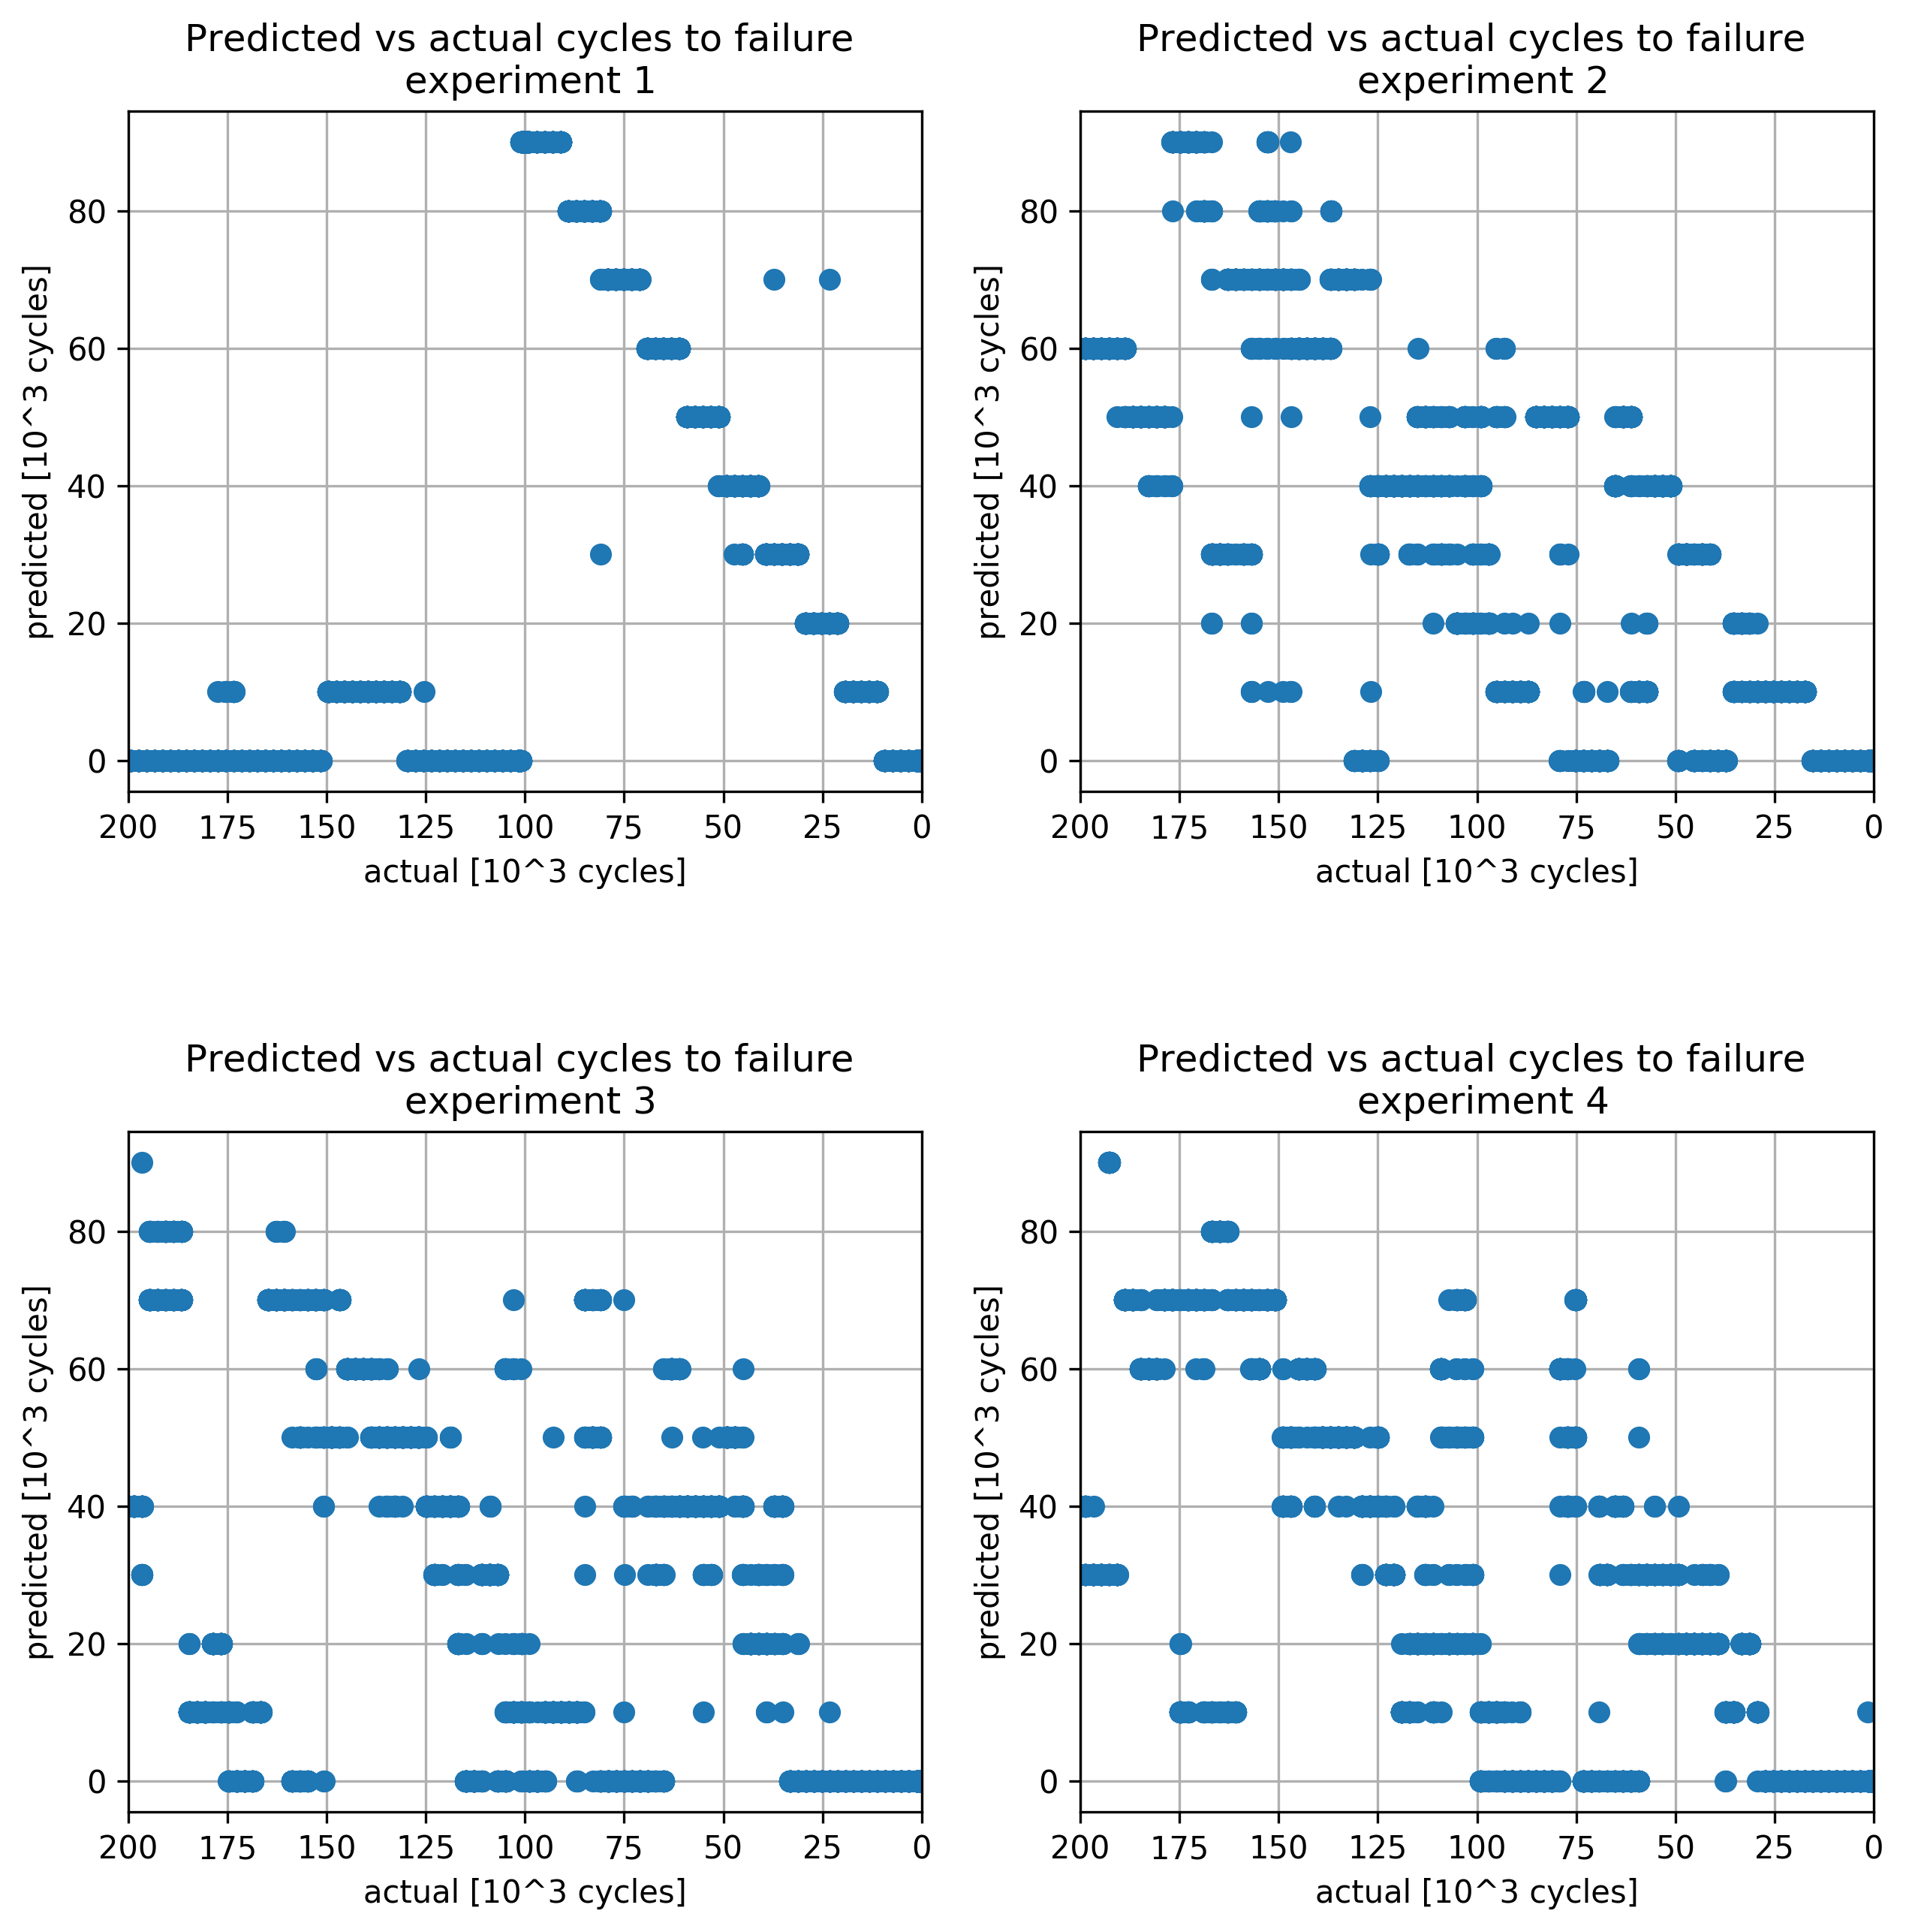

In [35]:
pplot.figure(figsize = (10,10), dpi = 300)
gen_adv_model.load_weights("model_closs%2.2f"%0.0)
for i in range(1,5):
    #data = load_hilti_fatigue_data(keep_from_end = 100000,leave_exp_out="None",stage_2_from_disk=True, nclasses = 10, user_normalization=static_normalization, use_ds = [i])
    #[X_all_,Y_all_,Yoh_all_, eid_vector_all_] = data['training_instances']
    yplot = Y_all_[eid_vector_all_ == 'VA_%i'%i]
    xdat  = X_all_[eid_vector_all_ == 'VA_%i'%i]
    res = gen_adv_model.predict(xdat, batch_size = 200)
    pplot.subplot(2,2,i)
    
    pplot.plot(yplot/1000,np.argmax(res[1],1)*10,'o');
    pplot.xlim([200,0])
    pplot.xlabel("actual [10^3 cycles]")
    pplot.ylabel("predicted [10^3 cycles]")
    #pplot.ylim([0,300000])
    pplot.title("Predicted vs actual cycles to failure \n experiment %i"%i);
    pplot.grid()
pplot.subplots_adjust(hspace=0.5)

In [81]:
#pplot.plot(Y_all_,np.argmax(res[1],1))


(6257, 10)

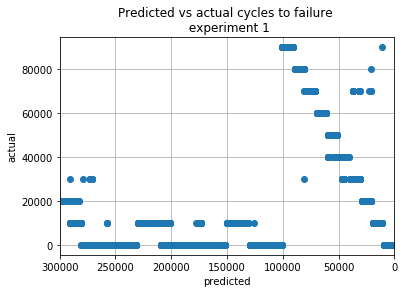

In [ ]:
tc = Top3AccStrong()#
tc.on_epoch_end(epoch = 0)


In [54]:
gen_adv_model.loss_weights['ExpID'].assign(0.2)
with keras.backend.get_session():
    gen_adv_model.loss_weights['ExpID'].assign(0.2)
    gen_adv_model.loss_weights['ExpID'].eval(session=keras.backend.get_session())


AttributeError: 'float' object has no attribute 'assign'

In [55]:
help(gen_adv_model.loss_weights['ExpID'].assign)

AttributeError: 'float' object has no attribute 'assign'

In [56]:
gen_adv_model._training_endpoints[0].loss_weight = 

SyntaxError: invalid syntax (<ipython-input-56-0858bdc05180>, line 1)

In [37]:
gen_adv_model.loss_weights

{'Y_output': 1,
 'ExpID': <tf.Variable 'Variable:0' shape=() dtype=float32>,
 'C0_task': <tf.Variable 'Variable:0' shape=() dtype=float32>,
 'C1_task': <tf.Variable 'Variable:0' shape=() dtype=float32>}

In [235]:
inspect_model = keras.Model(inputs = model.layers[0].input,outputs = model.get_layer("DN_DN1_Out").output)


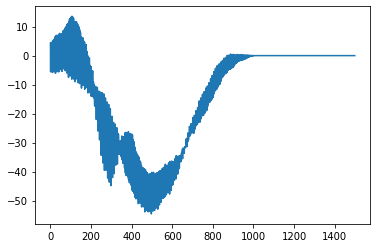

In [329]:
xx = Xtrain[0];
d1 = xx;#[np.newaxis]
dshift = np.zeros_like(d1)
pshift = 750
chan = 5;

dshift[0:pshift,chan] = np.random.randn(*dshift[0:pshift,chan].shape)*10
dshift.shape, d1.shape
v1 = (d1 + dshift)[np.newaxis]
v2 = d1[np.newaxis]
#d1_2 = d1 + np.hstack(np.random.randn()
n1 = (inspect_model(v1)[0,:,0].eval())
n2 = (inspect_model(v2)[0,:,0].eval())
pplot.plot(n1 - n2)
#pplot.plot(n2)


In [59]:

i1 = (Y_all_0 < 100000) * (Y_all_0 > 90000)
i2 = (Y_all_0 < 90000) * (Y_all_0 > 80000)
i3 = (Y_all_0 < 80000) * (Y_all_0 > 70000)
i4 = (Y_all_0 < 70000) * (Y_all_0 > 60000)
i5 = (Y_all_0 < 60000) * (Y_all_0 > 50000)
i6 = (Y_all_0 < 50000) * (Y_all_0 > 40000)

#i4 = (Y_all_0 < 70000) * (Y_all_0 > 60000)

ranges = [i1,i2,i3,i4,i5,i6]
vv = [];
eid_curr= [];
rcyc = [];
for k,ii_ in enumerate(ranges):
    #eevs = [  for ii_ in ranges]
    vv.append((np.mean(inspect_model.predict(X_all_0[ii_], batch_size = 100),1)))#, label = "range %i"%k)
    eid_curr.append( eid_vector_all_0[ii_])
    rcyc.append(Y_all_0[ii_])


In [60]:
def to_integer_vector(cat_vector):
    levels = np.unique(cat_vector)
    res = np.zeros_like(cat_vector)
    for kk,ll in enumerate(levels):
        
        res[cat_vector==ll] = kk
    return res



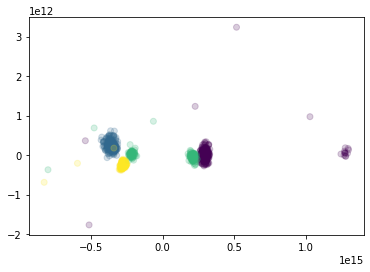

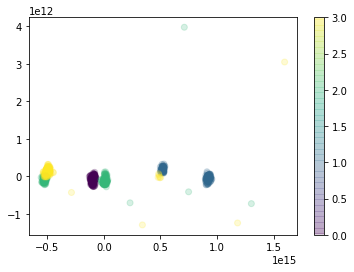

In [61]:
ranges_flat = np.hstack(ranges)
vv_ = np.vstack(vv)
vv_ = vv_ - np.mean(vv_)
vv_ = vv_.T / np.std(vv_,1)
#pplot.pcolor(vv_)
from sklearn.decomposition import PCA
pca = PCA(n_components=2)


range_val = 0;
p = pca.fit_transform(vv[range_val])
pplot.scatter(p[:,0],p[:,1], c = to_integer_vector(eid_curr[range_val]), alpha = 0.2)
pplot.show()
range_val = 2;
p = pca.fit_transform(vv[range_val])

pplot.scatter(p[:,0],p[:,1], c = to_integer_vector(eid_curr[range_val]), alpha = 0.2)
pplot.colorbar()

In [308]:

#eid_curr[0].shape

### Estimation of remaining cycles - consequtive blocks


In [311]:
## load the larger stage-2 dataset.
#del data
#data_orig = load_hilti_fatigue_data(keep_from_end=  300000,leave_exp_out="None",stage_2_from_disk=False, nclasses = 30, user_normalization = static_normalization)
#data = load_hilti_fatigue_data(keep_from_end=  300000,leave_exp_out="None",stage_2_from_disk=True, nclasses = 30)


In [312]:
#[X_all_large,Y_all_large,Yoh_all_large, eid_vector_all_large] = data_orig['training_instances']
[X_all_large,Y_all_large,Yoh_all_large, eid_vector_all_large] = [X_all_0,Y_all_0,Yoh_all_0, eid_vector_all_0] 


## Inspection of the evolution of the predictions
* The following are not confusion matrices. They are softmax scores for consecutive predictions. The bottom right block are the cycles closer to failure that are sampled with a higher resolution for all experiments.
* For the held-out experiment a trend towards failure for subsequent cycles in indeed followed. 
* For almost all samples less than 10k cycles from failure the prediction is very accurate (in the final stage of fatigue). 

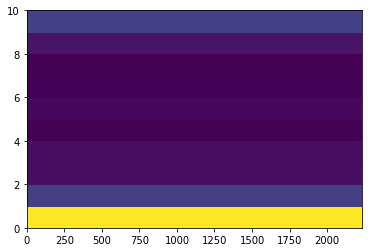

In [93]:
#pplot.plot(Y_all_large)
Xp  = X_all[eid_vector_all=='VA_3']
Yp = Y_all[eid_vector_all=='VA_3']
preds = gen_adv_model.predict(Xp, batch_size=100)
pplot.pcolor(tf.math.softmax(preds[1],axis = 1).eval().T)
pplot.show()


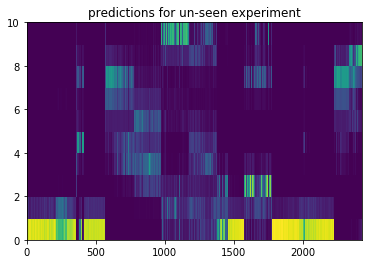

In [331]:
Xp  = X_all[eid_vector_all=='VA_1']
Yp = Y_all[eid_vector_all=='VA_1']
preds = model.predict(Xp, batch_size=100)
pplot.pcolor(tf.math.softmax(preds[1],axis = 1).eval().T)
pplot.title("predictions for un-seen experiment")
pplot.show()


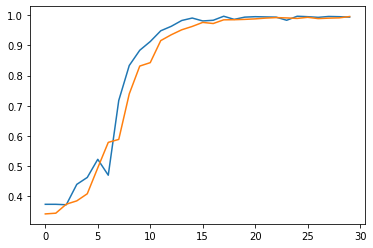

In [315]:
pplot.plot(history_d.history['val_Y_output_top3_acc'])
pplot.plot(history_d.history['Y_output_top3_acc'])

In [316]:

ii = inspect_model.predict(X_all[eid_vector_all == 'VA_3'][::10,:,:], batch_size=100)[:,::10,:]
ii2 = inspect_model.predict(X_all[eid_vector_all == 'VA_1'][::10,:,:], batch_size=100)[:,::10,:]
#ii2 = inspect_model.predict(X_all[eid_vector_all == 'VA_1'], batch_size=100)


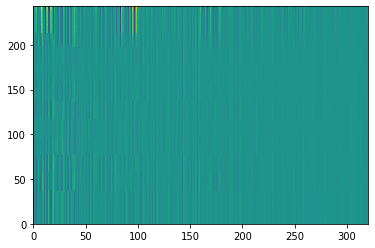

In [321]:
pplot.pcolor(np.mean(ii2,1))

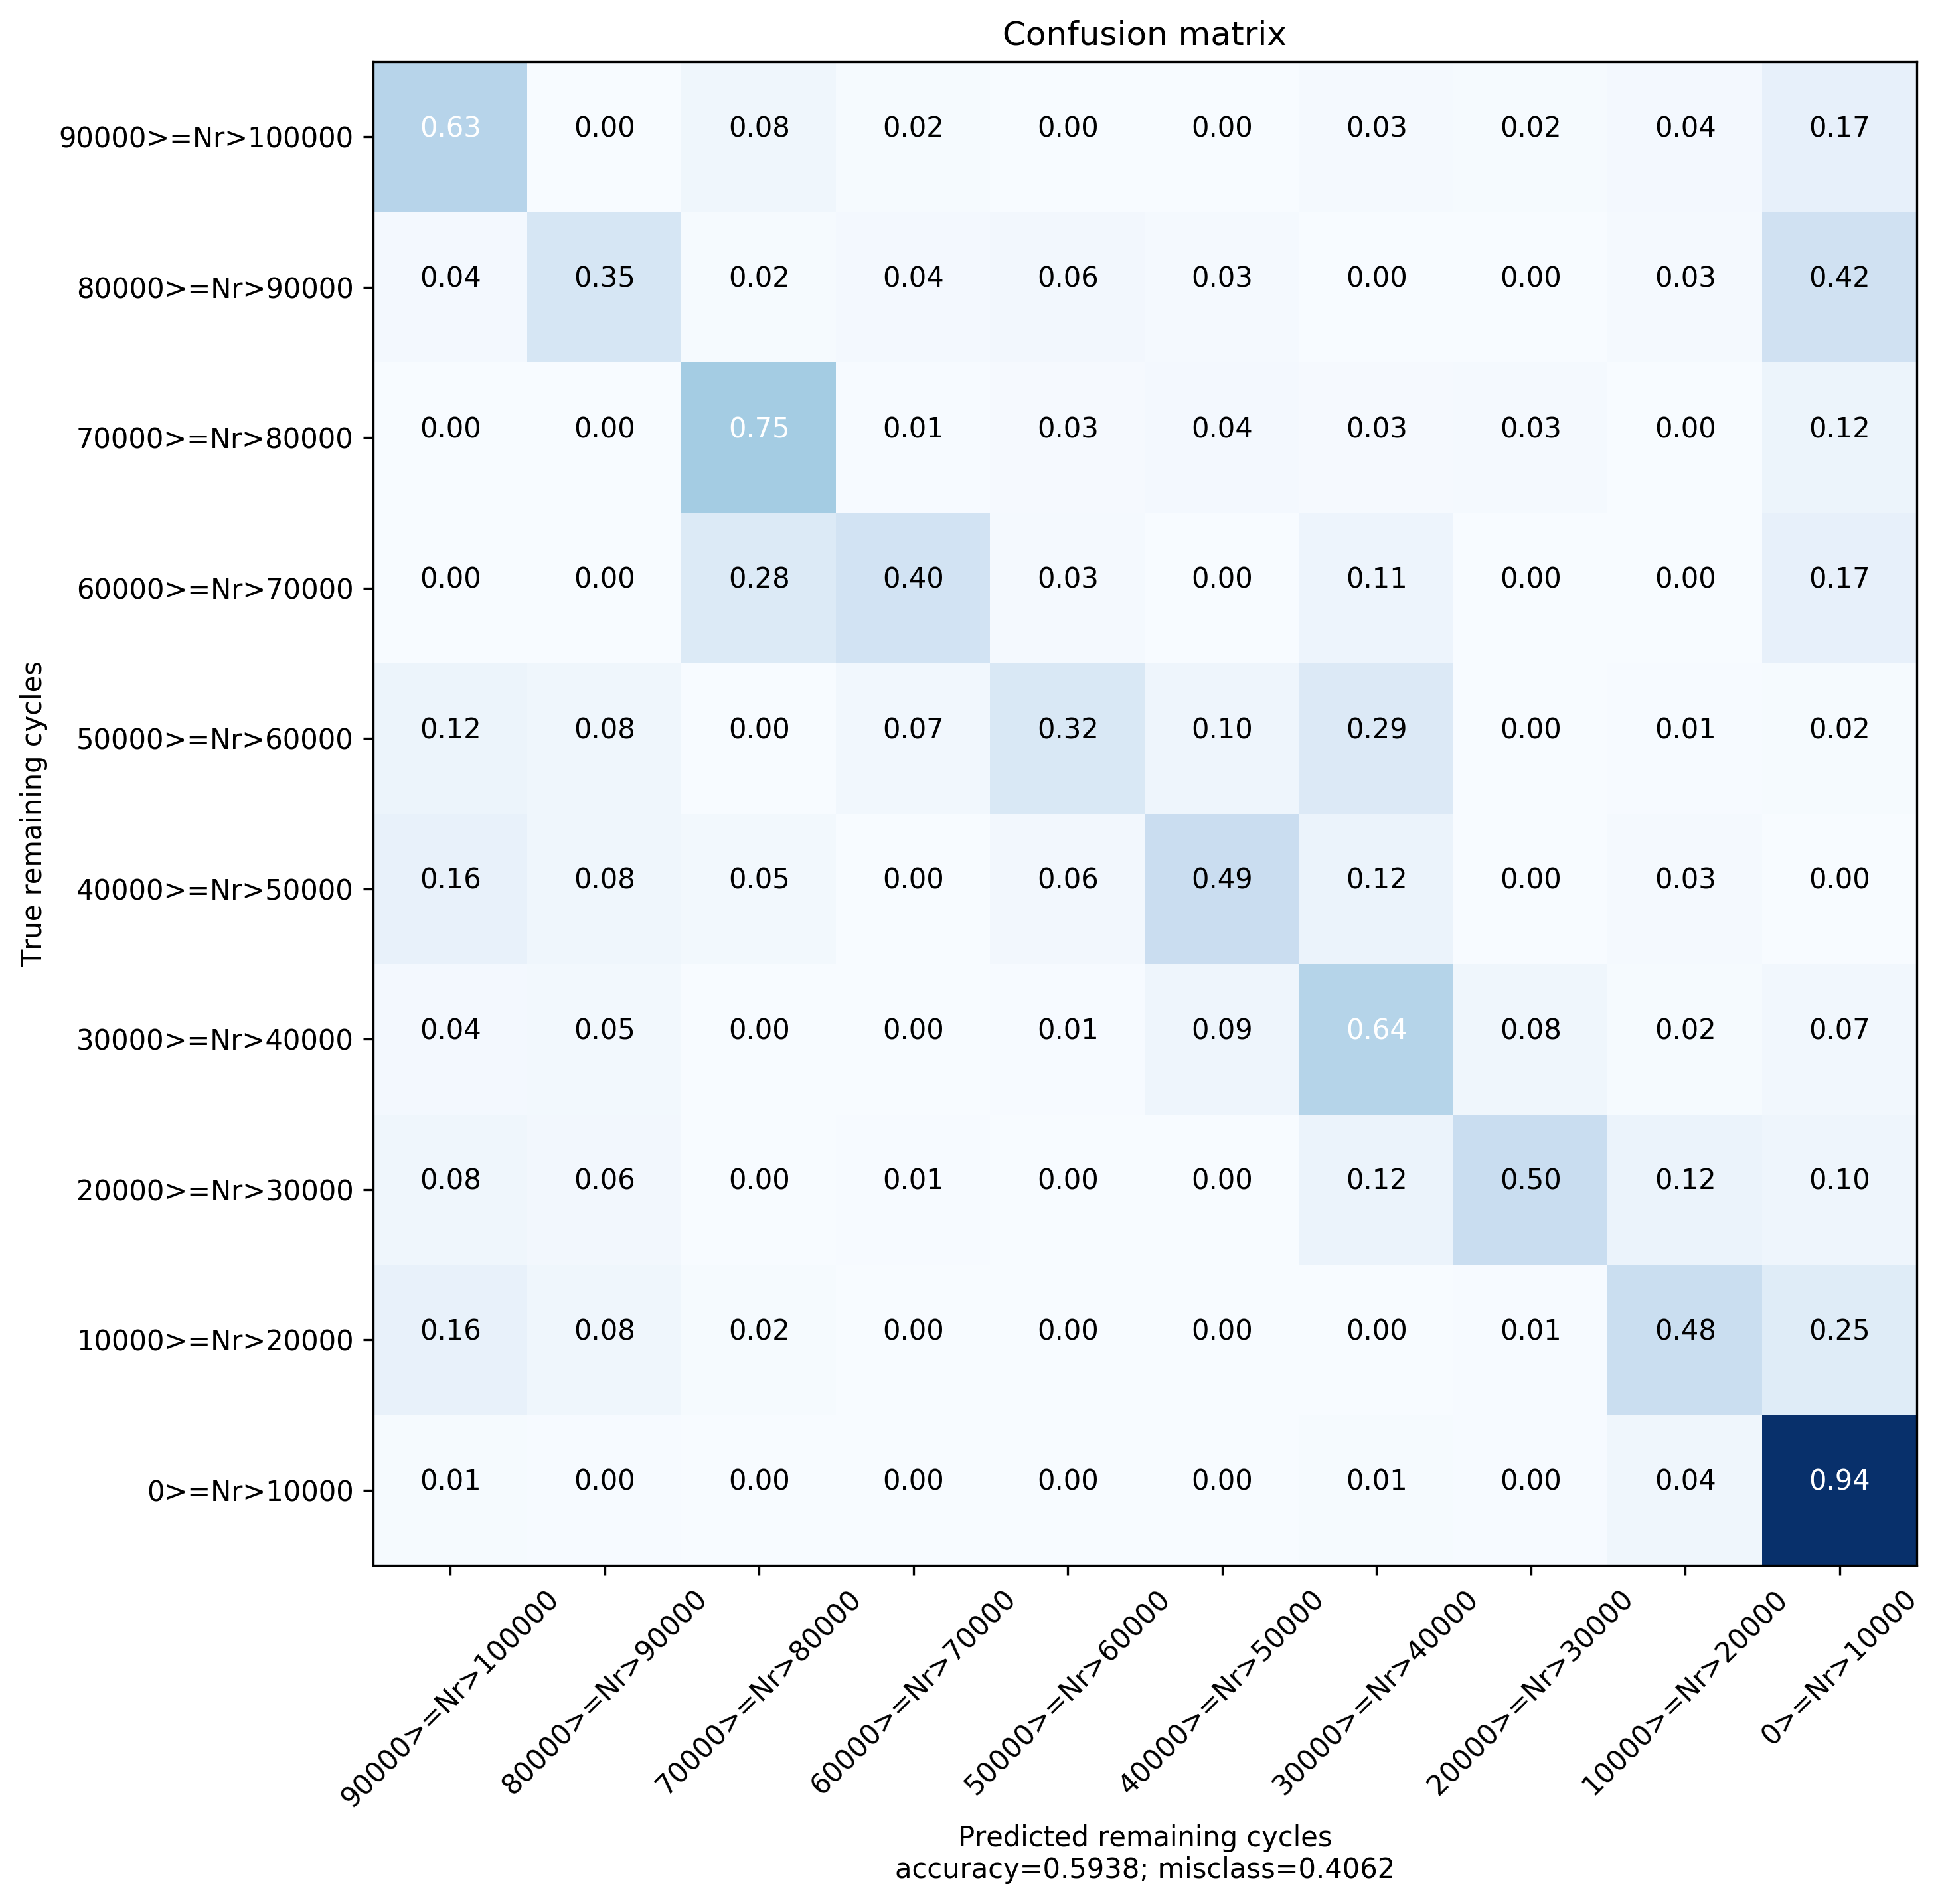

In [332]:
yhat = model.predict(Xtest, batch_size=100)[1]
crange = 10000
if tf.executing_eagerly():
    cmat = tf.confusion_matrix(tf.argmax(Ytest,1), tf.argmax(yhat,1)).numpy()
else:
    cmat = tf.confusion_matrix(tf.argmax(Ytest,1), tf.argmax(yhat,1)).eval(session = tf.keras.backend.get_session())
target_names = ["%i>=Nr>%i"%((i)*crange,(i+1)*crange) for i in range(int(cmat.shape[0]))]
plot_confusion_matrix(cmat, target_names = target_names, normalize=True)

In [227]:

#model.save("trained_model_VA2/model_")
model.summary()

Model: "model_15"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
timeseries_input (InputLayer)   [(None, 1500, 6)]    0                                            
__________________________________________________________________________________________________
DN_DN1_C1D (Conv1D)             (None, 1500, 20)     140         timeseries_input[0][0]           
__________________________________________________________________________________________________
DN_DN1_idx_0 (Sequential)       (None, 1500, 20)     4440        DN_DN1_C1D[0][0]                 
__________________________________________________________________________________________________
DN_DN1_idx_1 (Sequential)       (None, 1500, 20)     4440        DN_DN1_idx_0[0][0]               
                                                                 DN_DN1_C1D[0][0]          

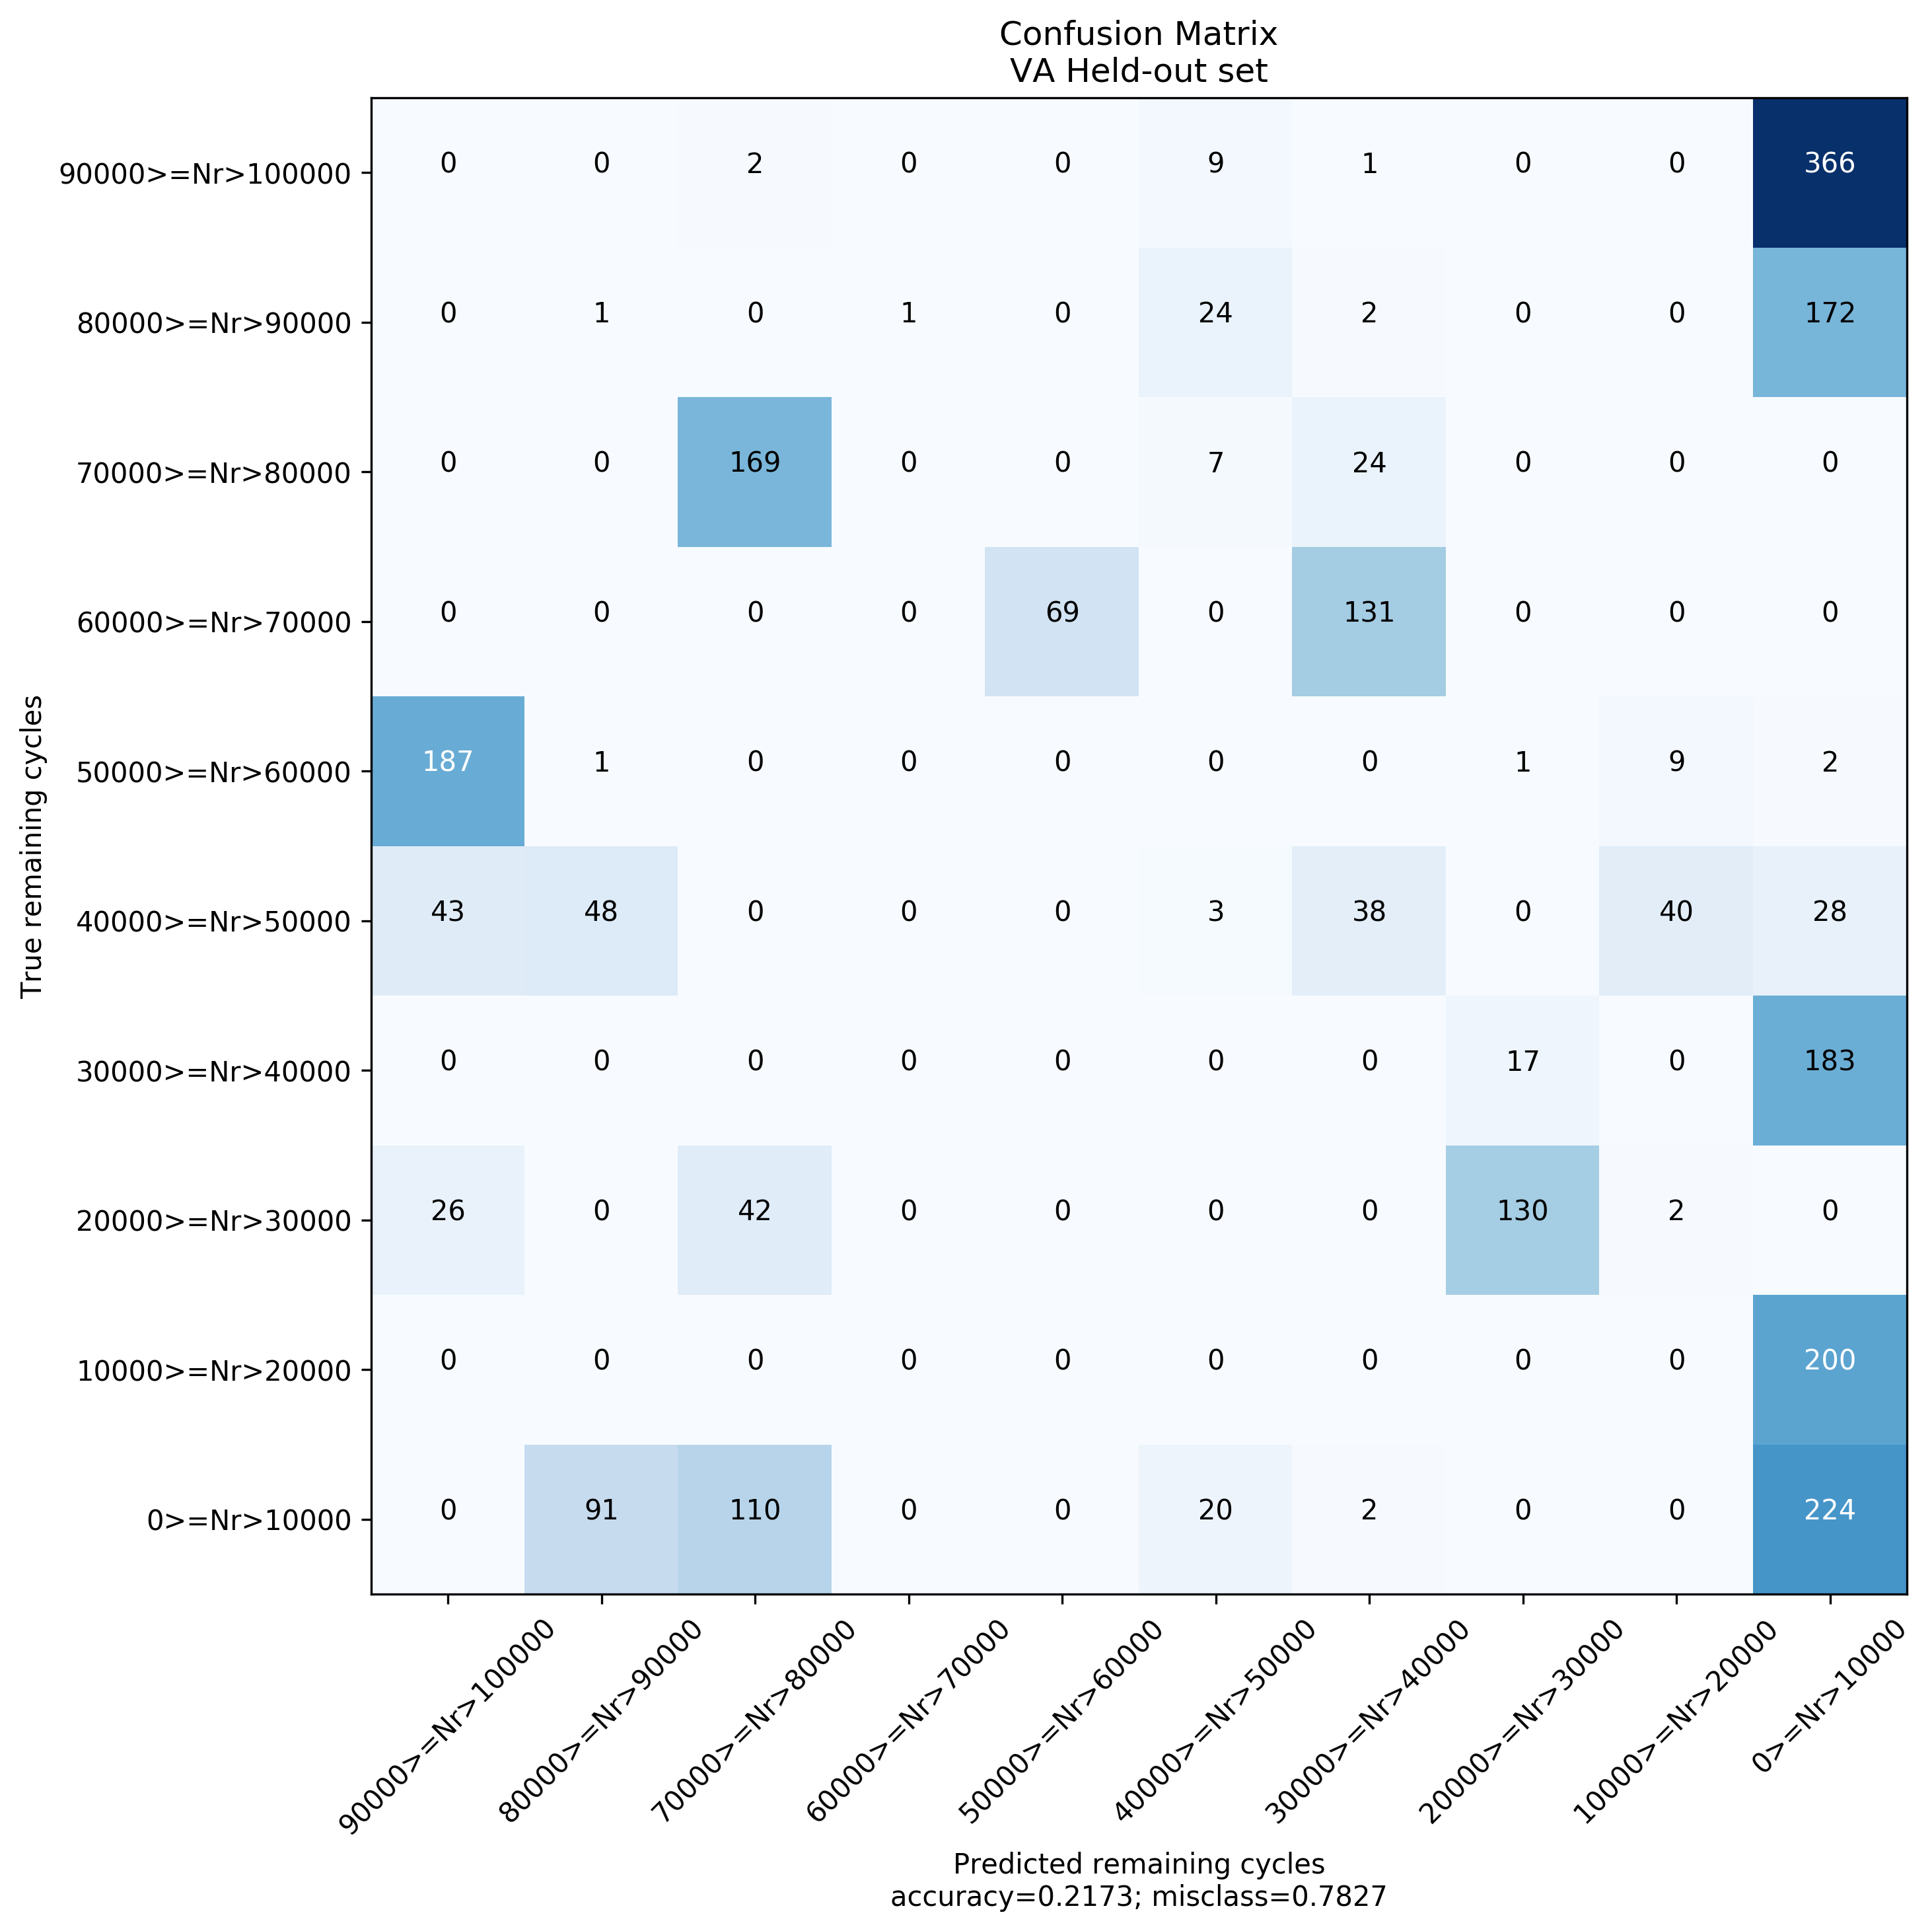

In [333]:
yyhat = model.predict(Xstrong)
cmat = confusion_matrix(np.argmax(YstrongOH,1),np.argmax(yyhat[1],1))
#cmat = cmat[0:-1,0:-1]
crange = int(150000/15);
target_names = ["%i>=Nr>%i"%((i)*crange,(i+1)*crange) for i in range(cmat.shape[0])]
plot_confusion_matrix(cmat.eval(session = keras.backend.get_session()),
                      target_names = target_names , figsize = (10,10), normalize= False, title = "Confusion Matrix\nVA Held-out set")
